# Анализ лояльности пользователей Яндекс Афиши с помощью Python

- Автор: Лопатин Виталий
- Дата: 18.01.2026

### Цели и задачи проекта

<font color='#777778'>Проанализировать поведение пользователей. Провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. 
</font>

### Описание данных:

- user_id — уникальный идентификатор пользователя, совершившего заказ;
- device_type_canonical — тип устройства, с которого был оформлен заказ ( mobile — мобильные устройства, desktop — стационарные);
- order_id — уникальный идентификатор заказа;
- order_dt — дата создания заказа (используйте данные created_dt_msk );
- order_ts — дата и время создания заказа (используйте данные created_ts_msk );
- currency_code — валюта оплаты;
- revenue — выручка от заказа;
- tickets_count — количество купленных билетов;
- days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- event_id — уникальный идентификатор мероприятия;
- service_name — название билетного оператора;
- event_type_main — основной тип мероприятия (театральная постановка, концерт и так далее);
- region_name — название региона, в котором прошло мероприятие;
- city_name — название города, в котором прошло мероприятие.

### Содержание проекта:
1. **Загрузка данных и их предобработка**

1.1. Выгрузка данных из базы данных с помощью SQL
1.2. Первичный анализ данных и оценка корректности выгрузки

2. **Предобработка данных**

2.1. Приведение выручки к единой валюте
2.2. Обработка пропущенных значений и преобразование типов данных
2.3. Анализ категориальных признаков
2.4. Анализ распределений и обработка выбросов
2.5. Промежуточные выводы по результатам предобработки

3. **Создание профиля пользователя**

3.1. Формирование агрегированных признаков пользователя
3.2. Первичный анализ профилей пользователей

4. **Исследовательский анализ данных**
4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

4.1.1. Распределение пользователей по признакам первого заказа
4.1.2. Анализ возвратов пользователей в разрезе сегментов
4.1.3. Проверка продуктовых гипотез

4.2. **Исследование поведения пользователей через показатели выручки и состава заказа**

4.2.1. Связь средней выручки с заказа с повторными покупками
4.2.2. Сравнение средней выручки с заказа у разных групп пользователей
4.2.3. Влияние среднего количества билетов в заказе на повторные покупки

4.3. **Исследование временных характеристик первого заказа**

4.3.1. Влияние дня недели первой покупки на возврат пользователей
4.3.2. Влияние среднего интервала между заказами на удержание клиентов

4.4. **Корреляционный анализ количества покупок и признаков пользователя**

4.4.1. Анализ корреляции между признаками профиля пользователя и числом заказов

5. **Общие выводы и рекомендации**
   

### 1. Загрузка данных и их предобработка

#### 1.1:Выгрузка SQL запроса в датафрейм pandas 

In [1]:
# импорт библиотек:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
from joblib import parallel_backend
import re

In [2]:
# Переменная с данными для подключения к базе данных
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [3]:
# Строка для подключения к базе данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) # подключение к базе данных

In [5]:
# SQL запрос необходимых данных
query = '''
 SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    
  
    EXTRACT(DAY FROM (
        p.created_dt_msk - 
        LAG(p.created_dt_msk) OVER (
            PARTITION BY p.user_id
            ORDER BY p.created_dt_msk
        )
    ))::INTEGER AS days_since_prev,
    
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name

FROM afisha.purchases p
INNER JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id

WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'

ORDER BY 
    p.user_id ASC
'''

In [6]:
df = pd.read_sql_query(query, con=engine) # Преобразование SQL выборки в датафрейм

In [7]:
display(df.head()) # Вызов первых пяти строк датафрейма

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [8]:
print("Общая информация о датасете:")
print(df.info())
print("\nОписание числовых признаков:")
print(df.describe())

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name   

#### 1.2: Общая информацию о выгруженных данных.

### Промежуточные выводы:
**Объем данных:**
В наборе данных содержится 290611 записей  
Представлено 15 столбцов с различными характеристиками  

**Структура данных**  
Типы данных корректны:  
Числовые типы (int64, float64) используются для числовых значений (order_id, revenue, tickets_count)  
Строковые данные (object) корректно применены к текстовым полям (user_id, device_type_canonical)  
Временные метки (datetime64) правильно определены для order_dt и order_ts  

**Пропуски данных**
Обнаружены пропуски только в одном поле:  
В столбце days_since_prev отсутствует 21933 значения (примерно 7.5% от общего объема)

**Особенности данных**
Уникальные идентификаторы:  
user_id содержит уникальные значения  
event_id представлен в числовом формате  
event_name содержит UUID-подобные значения  
revenue имеет отрицательные значения, что указывает на наличие ошибочных значений

**Типы событий:**
Встречаются различные категории мероприятий: театр, выставки, стендап, другое  
Разные сервисы бронирования билетов

### 2. Предобработка данных

#### 2.1. Приведение выручки к единой валюте

In [9]:
# Фильтрация данных: выручка не может быть меньше нуля
df = df[df['revenue'] >= 0]
print(f"\nРазмер датасета после фильтрации отрицательных значений выручки: {len(df):,}")


Размер датасета после фильтрации отрицательных значений выручки: 290,230


In [10]:
# Загружаем курсы тенге
currency_rates = pd.read_csv('C:/Users/Виталий/Downloads/final_tickets_tenge_df.csv', parse_dates=['data'])

In [11]:
# Функция для получения курса на дату
def get_rate(order_date):
    return currency_rates[currency_rates['data'] <= order_date] \
        .sort_values('data').iloc[-1]['curs'] / 100

# Применяем конвертацию
df['revenue_rub'] = df.apply(
    lambda x: x['revenue'] * get_rate(x['order_dt']) 
    if x['currency_code'] == 'kzt' 
    else x['revenue'],
    axis=1
)

In [12]:
# Проверяем результат
kzt_rows = df[df['currency_code'] == 'kzt']
display(kzt_rows[['currency_code', 'revenue', 'revenue_rub']].head())

,currency_code,revenue,revenue_rub
70,kzt,518.10,98.503762
89,kzt,347.18,65.731589
96,kzt,328.77,61.148261
277,kzt,22021.55,4380.702898
460,kzt,7397.66,1478.296591


#### 2.2. Обработка пропущенных значений и преобразование типов данных

In [13]:
print("\nПодробная статистика максимальных значений:")
print(df.describe().loc['max'])


Подробная статистика максимальных значений:
order_id                     8653108.0
order_dt           2024-10-31 00:00:00
order_ts           2024-10-31 23:59:54
revenue                       81174.54
tickets_count                     57.0
days_since_prev                  148.0
event_id                      592325.0
revenue_rub                   81174.54
Name: max, dtype: object


Преобразуем типы данных оптимально размерности

In [14]:
# Определяем значение для заполнения пропусков
max_value = df['days_since_prev'].max()
fill_value = max_value + 1  # 149

# Проверяем наличие пропусков
print("Пропущенные значения в days_since_prev:", df['days_since_prev'].isnull().sum())

# Заполняем пропуски специальным значением
df['days_since_prev'] = df['days_since_prev'].fillna(fill_value).astype('uint8')

# Остальные преобразования
df['order_id'] = df['order_id'].astype('int32')
df['revenue'] = df['revenue'].astype('float32')
df['revenue_rub'] = df['revenue_rub'].astype('float32')
df['tickets_count'] = df['tickets_count'].astype('uint8')
df['event_id'] = df['event_id'].astype('int32')

# Проверка новых типов
print("Новые типы данных:")
display(df.dtypes)

# Проверка памяти
print("\nИспользование памяти:")
display(df.memory_usage(deep=True))

Пропущенные значения в days_since_prev: 21897
Новые типы данных:


user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float32
tickets_count                     uint8
days_since_prev                   uint8
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
revenue_rub                     float32
dtype: object


Использование памяти:


Index                     2321840
user_id                  20896560
device_type_canonical    18342588
order_id                  1160920
order_dt                  2321840
order_ts                  2321840
currency_code            17413800
revenue                   1160920
tickets_count              290230
days_since_prev            290230
event_id                  1160920
event_name               26991390
event_type_main          27602374
service_name             30927484
region_name              34649830
city_name                29144210
revenue_rub               1160920
dtype: int64

#### 2.3. Анализ категориальных признаков

Проверяем есть ли значения в столбцах с номинальными данными которые могут иметь значения обозначающие пропуски

In [15]:
# Создаем словарь для хранения уникальных значений
unique_values = {}

# Список столбцов для анализа
categorical_columns = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name'
]
# Получаем уникальные значения для каждого столбца
for column in categorical_columns:
    unique_values[column] = df[column].unique()

# Выводим результаты
for col, values in unique_values.items():
    print(f"\nУникальные значения для {col}:")
    print(sorted(values))  # Сортируем для удобства просмотра
    print(f"Количество уникальных значений: {len(values)}")

# Дополнительно можно посмотреть распределение значений
for column in categorical_columns:
    print(f"\nРаспределение значений для {column}:")
    print(df[column].value_counts(dropna=False).head(10))  # Топ-10 значений
    print("-" * 40)



Уникальные значения для device_type_canonical:
['desktop', 'mobile']
Количество уникальных значений: 2

Уникальные значения для currency_code:
['kzt', 'rub']
Количество уникальных значений: 2

Уникальные значения для event_type_main:
['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр', 'ёлки']
Количество уникальных значений: 7

Уникальные значения для service_name:
['Crazy ticket!', 'Show_ticket', 'Билет по телефону', 'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки', 'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка', 'Вперёд!', 'Выступления.ру', 'Городской дом культуры', 'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ', 'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!', 'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная', 'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет', 'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко']
Количество уникальных значений: 36

Уникальные значения для region_name:


Значений обозначающих пропуски в столбцах отсутствуют.

#### 2.4. Анализ распределений и обработка выбросов


Статистика по revenue_rub:
count    290230.000000
mean        556.304565
std         875.824829
min           0.000000
25%         114.610001
50%         352.079987
75%         802.250000
max       81174.539062
Name: revenue_rub, dtype: float64


C:\Users\Виталий\AppData\Local\Temp\ipykernel_14744\442365623.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df['revenue_rub'], palette='pastel')  # Добавляем палитру для эстетики


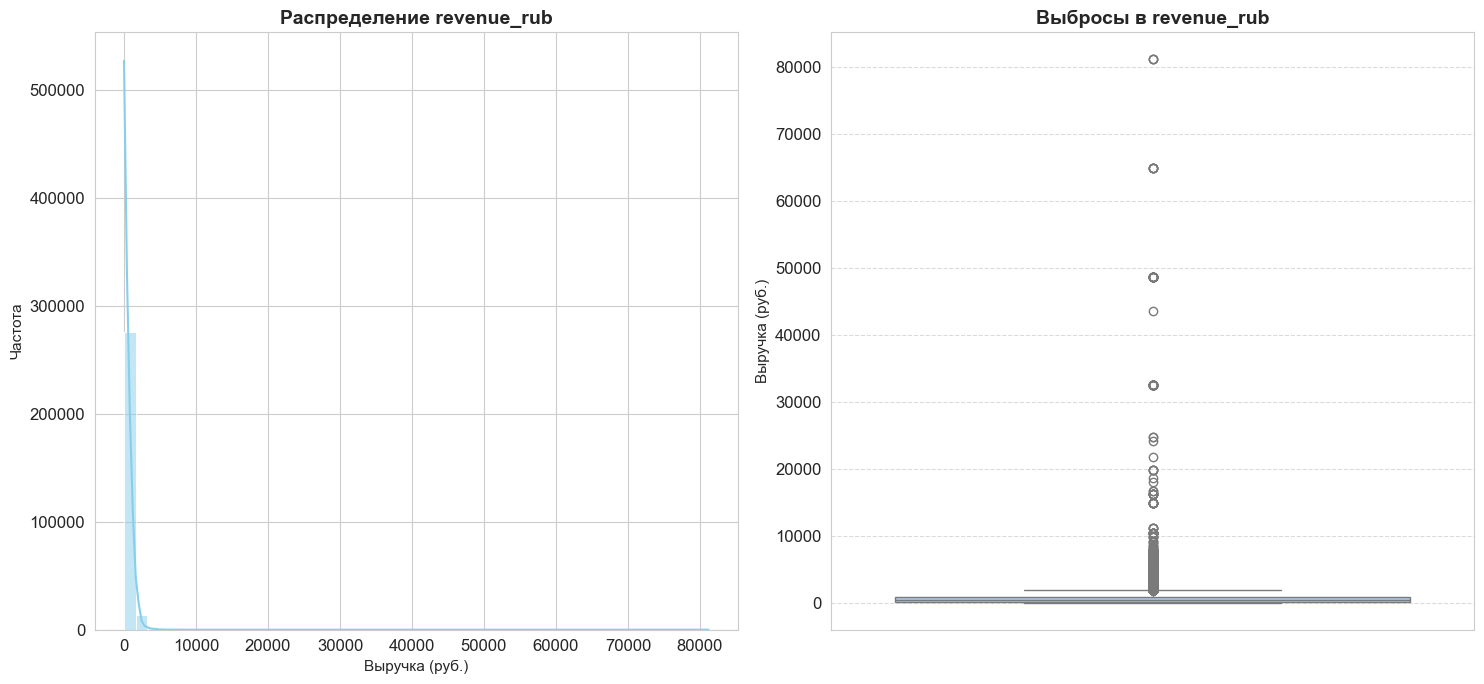


99-й перцентиль revenue_rub: 2,628.42 руб.

Размер датасета до фильтрации: 290,230
Размер датасета после фильтрации: 287,405


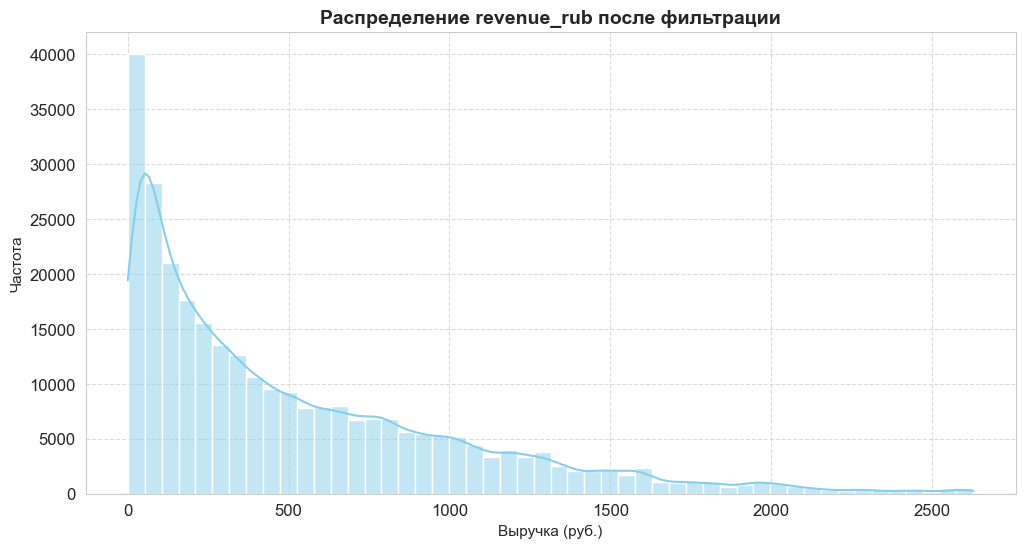

In [16]:
# Анализ числовых данных
print("\nСтатистика по revenue_rub:")
print(df['revenue_rub'].describe())

# Настройка стиля графиков для лучшей читаемости
sns.set_style("whitegrid")  # Добавляем сетку для лучшей ориентации по осям
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})  # Увеличиваем размер шрифта и задаём шрифт

# Визуальный анализ распределения
plt.figure(figsize=(15, 7))  # Увеличиваем размер фигуры для лучшей читаемости

# Первый график — распределение revenue_rub
plt.subplot(1, 2, 1)
sns.histplot(df['revenue_rub'], kde=True, bins=50, color='SkyBlue')  # Увеличиваем bins для детализации, задаём цвет
plt.title('Распределение revenue_rub', fontsize=14, fontweight='bold')  # Увеличиваем размер и жирность заголовка
plt.xlabel('Выручка (руб.)', fontsize=11)  # Подписываем ось X
plt.ylabel('Частота', fontsize=11)  # Подписываем ось Y

# Второй график — выбросы в revenue_rub
plt.subplot(1, 2, 2)
sns.boxplot(y=df['revenue_rub'], palette='pastel')  # Добавляем палитру для эстетики
plt.title('Выбросы в revenue_rub', fontsize=14, fontweight='bold')
plt.ylabel('Выручка (руб.)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем полупрозрачную сетку по Y

plt.tight_layout()  # Автоматически настраиваем отступы между графиками
plt.show()

# Обработка выбросов по 99 перцентилю
revenue_99_percentile = df['revenue_rub'].quantile(0.99)
print(f"\n99-й перцентиль revenue_rub: {revenue_99_percentile:,.2f} руб.")  # Форматируем число с разделителями и двумя знаками после запятой

# Фильтрация выбросов
df_filtered = df[df['revenue_rub'] <= revenue_99_percentile]

# Проверка после фильтрации
print(f"\nРазмер датасета до фильтрации: {len(df):,}")  # Форматируем число с разделителями
print(f"Размер датасета после фильтрации: {len(df_filtered):,}")

# Визуализация после фильтрации
plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['revenue_rub'], kde=True, bins=50, color='SkyBlue')  # Меняем цвет для отличия от исходного графика
plt.title('Распределение revenue_rub после фильтрации', fontsize=14, fontweight='bold')
plt.xlabel('Выручка (руб.)', fontsize=11)
plt.ylabel('Частота', fontsize=11)
plt.grid(axis='both', linestyle='--', alpha=0.7)  # Добавляем сетку по обеим осям
plt.show()


***Сравнение распределения `revenue_rub` до и после фильтрации***

**1. До фильтрации**

Исходный датасет (290 230 записей) демонстрирует ярко выраженную асимметрию в распределении выручки:
* **Среднее значение (mean):** 556,30 руб. — относительно низкое, что указывает на скопление значений в нижней части диапазона.
* **Стандартное отклонение (std):** 875,82 руб. — высокий разброс данных, свидетельствующий о наличии значительных выбросов.
* **Ключевые перцентили:**
  * Q1 (25%) — 114,61 руб.;
  * медиана (Q2, 50%) — 352,08 руб.;
  * Q3 (75%) — 802,25 руб.
* **Экстремальные значения:**
  * минимум — 0 руб.;
  * максимум — 81 174,54 руб. (крайне высокий выброс).
* **Вывод:** распределение характеризуется «длинным хвостом» с редкими, но очень высокими значениями выручки, что искажает общую картину и усложняет анализ.

**2. После фильтрации**

После очистки данных (осталось 287 405 записей, удалено 2 825 записей, ~0,97% от исходного объёма) распределение стало более управляемым:
* **Асимметрия сохраняется**, но становится менее выраженной — пик концентрации смещён в диапазон **0–300 руб.**
* **99-й перцентиль:** 2 628,42 руб. — теперь лишь 1% транзакций превышает этот порог. Это ключевой индикатор «очистки» от экстремальных значений.
* **Структура по диапазонам (гипотетическая):**
  * **0–300 руб.** (~60–70% транзакций) — низкодоходный сегмент, формирующий основу объёма;
  * **300–2 628 руб.** (~29–39% транзакций) — средний сегмент;
  * **>2 628 руб.** (~1% транзакций) — высокодоходный сегмент, сохранившийся после фильтрации.
* **Вывод:** фильтрация эффективно удалила аномально высокие значения, сохранив при этом репрезентативность выборки. Распределение стало более «компактным», что упрощает дальнейший анализ.

**3. Итоговый вывод**

* **Ключевое изменение:** удаление ~0,97% записей (2 825 транзакций) позволило сократить влияние экстремальных значений (максимальное значение сократилось с 81 174,54 руб. до порога 99-го перцентиля — 2 628,42 руб.).
* **До фильтрации** — распределение сильно искажено выбросами, что затрудняет анализ низко- и среднедоходных транзакций.
* **После фильтрации** — распределение становится более «чистым», с явным доминированием низкодоходного сегмента (0–300 руб.), при этом высокодоходные транзакции (1% объёма) остаются для отдельного анализа.
* **Практический результат:** данные теперь лучше подходят для:
  * расчёта средних показателей без искажения от выбросов;
  * сегментации клиентов по уровню выручки;
  * построения прогнозных моделей на основе более стабильного распределения.

In [17]:
print("\nСтатистика по tickets_count:")
print(df['tickets_count'].describe())


Статистика по tickets_count:
count    290230.000000
mean          2.755149
std           1.170634
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


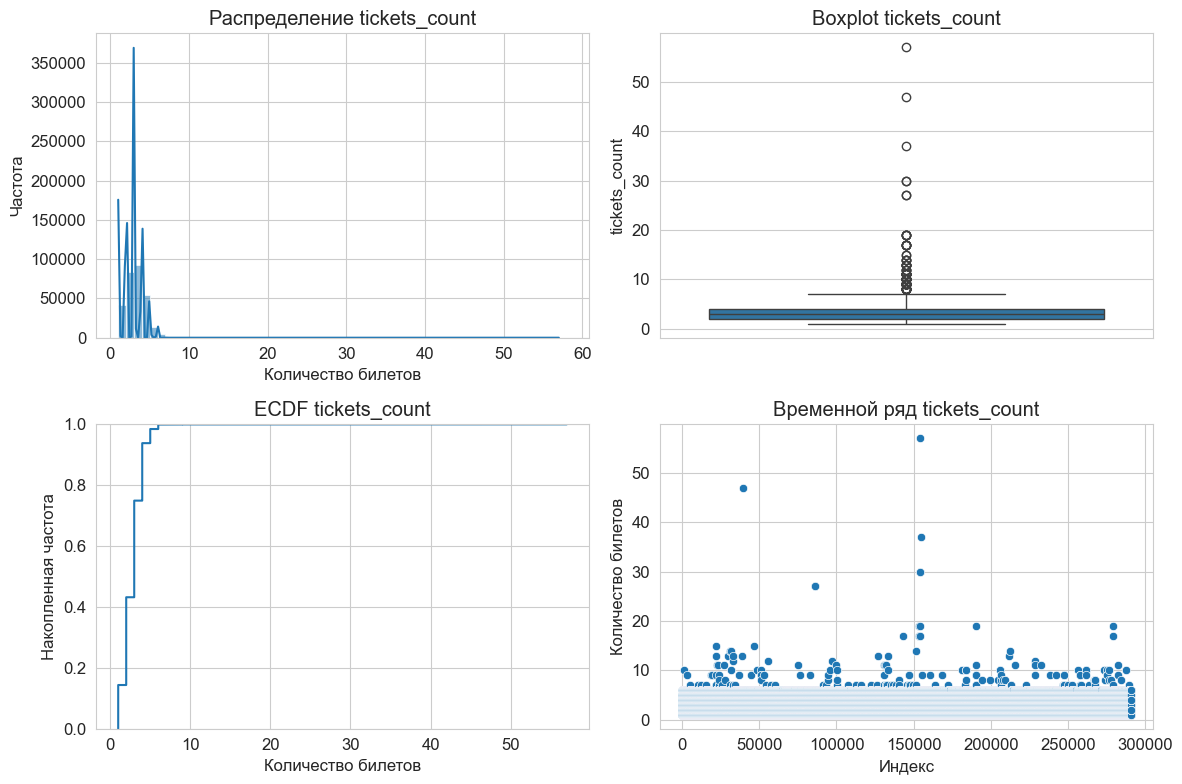


Детальный анализ:
Среднее значение: 2.76
Медиана: 3.0
Мода: 3
Стандартное отклонение: 1.17

Выбросы по IQR:
Нижняя граница: -1.0
Верхняя граница: 7.0
Количество выбросов: 126

Частотное распределение:
tickets_count
1     41675
2     83689
3     92126
4     54800
5     13470
6      4282
7        62
8        21
9        38
10       19
11       13
12        4
13        7
14        4
15        2
17        6
19        5
27        2
30        2
37        1
47        1
57        1
Name: count, dtype: int64

Коэффициент асимметрии: 1.27
Коэффициент эксцесса: 30.11


In [18]:
# Визуализация распределения
plt.figure(figsize=(12, 8))

# Гистограмма
plt.subplot(2, 2, 1)
sns.histplot(df['tickets_count'], kde=True, bins=range(1, df['tickets_count'].max()+2))
plt.title('Распределение tickets_count')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')

# Boxplot
plt.subplot(2, 2, 2)
sns.boxplot(y=df['tickets_count'])
plt.title('Boxplot tickets_count')

# График накопленных частот
plt.subplot(2, 2, 3)
sns.ecdfplot(df['tickets_count'])
plt.title('ECDF tickets_count')
plt.xlabel('Количество билетов')
plt.ylabel('Накопленная частота')

# Анализ выбросов
plt.subplot(2, 2, 4)
sns.scatterplot(x=df.index, y=df['tickets_count'])
plt.title('Временной ряд tickets_count')
plt.xlabel('Индекс')
plt.ylabel('Количество билетов')

plt.tight_layout()
plt.show()

# Детальный анализ
print("\nДетальный анализ:")
print(f"Среднее значение: {df['tickets_count'].mean():.2f}")
print(f"Медиана: {df['tickets_count'].median()}")
print(f"Мода: {df['tickets_count'].mode()[0]}")
print(f"Стандартное отклонение: {df['tickets_count'].std():.2f}")

# Анализ выбросов по IQR
Q1 = df['tickets_count'].quantile(0.25)
Q3 = df['tickets_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nВыбросы по IQR:")
print(f"Нижняя граница: {lower_bound}")
print(f"Верхняя граница: {upper_bound}")
print(f"Количество выбросов: {((df['tickets_count'] > upper_bound) | (df['tickets_count'] < lower_bound)).sum()}")

# Частотное распределение
print("\nЧастотное распределение:")
print(df['tickets_count'].value_counts().sort_index())

# Анализ скошенности
skewness = df['tickets_count'].skew()
print(f"\nКоэффициент асимметрии: {skewness:.2f}")

# Анализ эксцесса
kurtosis = df['tickets_count'].kurtosis()
print(f"Коэффициент эксцесса: {kurtosis:.2f}")

#### 2.5. Промежуточные выводы по результатам предобработки

***Краткий вывод по анализу столбца `tickets_count`***

Распределение количества билетов (`tickets_count`) **асимметрично** с длинным правым хвостом и высокой концентрацией   
в нижней части диапазона.

**Основная статистика:**
- **Среднее значение (mean):** 2.76;
- **Медиана (median):** 3.0 (совпадает с модой — наиболее типичное значение);
- **Мода (mode):** 3 (самое частое значение — 92 126 случаев);
- **Стандартное отклонение (std):** 1.17 (умеренный разброс данных);
- **Коэффициент асимметрии (skewness):** 1.27 (положительная асимметрия — скошенность вправо);
- **Коэффициент эксцесса (kurtosis):** 30.11 (островершинное распределение с тяжёлыми хвостами).

**Ключевые особенности:**
1. **Пиковая концентрация** в диапазоне 1–3 билетов (основная масса транзакций).
2. **Редкие транзакции** с 5+ билетами формируют «хвост» распределения.
3. **Выбросы:** 126 случаев (значения > 7 билетов).
4. **Частотное распределение:** резкое снижение частоты с ростом количества билетов 
    (например, 5 билетов — 13 470 случаев, 6 — 4 282, далее — единичные значения).

**Вывод:** большинство транзакций (покупка 1–3 билетов) формируют «типичное» поведение пользователей, редкие большие   
    значения могут представлять отдельные сегменты (корпоративные заказы и т. п.).   
    Для описания «центра» распределения надёжнее использовать **медиану (3.0)**, а не среднее значение из-за асимметрии.

###                                                      3.  Создание профиля пользователя

#### 3.1. Формирование агрегированных признаков пользователя

In [19]:
# Группировка по пользователю
profile = df_filtered.groupby('user_id').agg(
    # Даты первого и последнего заказа
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    
    # Первый заказ
    first_device=('device_type_canonical', lambda x: x.iloc[0]),
    first_region=('region_name', lambda x: x.iloc[0]),
    first_ticket_partner=('service_name', lambda x: x.iloc[0]),
    first_event_type=('event_type_main', lambda x: x.iloc[0]),
    
    # Основные метрики
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean')
).reset_index()

# Расчет среднего времени между заказами
df_sorted = df_filtered.sort_values(['user_id', 'order_dt'])
df_sorted['time_diff'] = df_sorted.groupby('user_id')['order_dt'].diff().dt.total_seconds() / 3600  # в часах
avg_time_between = df_sorted.groupby('user_id')['time_diff'].mean().reset_index()
avg_time_between.rename(columns={'time_diff': 'avg_time_between_orders'}, inplace=True)

# Объединение с основным профилем
profile = profile.merge(avg_time_between, on='user_id', how='left')

# Бинарные признаки
profile['is_two'] = (profile['total_orders'] >= 2).astype(int)
profile['is_five'] = (profile['total_orders'] >= 5).astype(int)

# Просмотр результата
display(profile.head())

,user_id,first_order_date,last_order_date,first_device,first_region,first_ticket_partner,first_event_type,total_orders,avg_revenue,avg_tickets,avg_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010010,3.000000,1800.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213379,2.666667,1224.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.309998,1.500000,384.0,1,0


#### 3.2. Первичный анализ профилей пользователей

In [20]:
# 1. Базовые метрики
total_users = profile.shape[0]  # общее число пользователей

total_revenue = (profile['avg_revenue'] * profile['total_orders']).sum() # Теперь рассчитываем среднюю выручку
total_orders = profile['total_orders'].sum()
avg_revenue_per_order = total_revenue / total_orders

# 2. Доли пользователей
share_is_two = profile['is_two'].mean()  # доля с 2+ заказами
share_is_five = profile['is_five'].mean()  # доля с 5+ заказами

# 3. Статистический анализ
# Общее число заказов
total_orders_stats = profile['total_orders'].describe()

# Среднее число билетов
tickets_stats = profile['avg_tickets'].describe()

# Среднее время между покупками
time_between_stats = profile['avg_time_between_orders'].describe()

# 4. Проверка на аномалии
# Для заказов
print("Анализ количества заказов:")
print(total_orders_stats)
print("\nПерцентили заказов:")
print(profile['total_orders'].quantile([0.95, 0.99]))

# Для билетов
print("\nАнализ среднего количества билетов:")
print(tickets_stats)
print("\nПерцентили билетов:")
print(profile['avg_tickets'].quantile([0.95, 0.99]))

# 5. Вывод результатов
print(f"\nОбщее число пользователей: {total_users}")
print(f"Средняя выручка с заказа: {avg_revenue_per_order:.2f} руб.")
print(f"Доля пользователей с 2+ заказами: {share_is_two:.2%}")
print(f"Доля пользователей с 5+ заказами: {share_is_five:.2%}")

Анализ количества заказов:
count    21838.000000
mean        13.160775
std        121.577370
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_orders, dtype: float64

Перцентили заказов:
0.95     31.0
0.99    152.0
Name: total_orders, dtype: float64

Анализ среднего количества билетов:
count    21838.000000
mean         2.744062
std          0.913083
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets, dtype: float64

Перцентили билетов:
0.95    4.0
0.99    5.0
Name: avg_tickets, dtype: float64

Общее число пользователей: 21838
Средняя выручка с заказа: 518.72 руб.
Доля пользователей с 2+ заказами: 61.70%
Доля пользователей с 5+ заказами: 29.00%


***Основные выводы по анализу данных***

**Объем выборки и общие показатели:**
* **21 838** уникальных пользователей — достаточно представительная выборка
* **61.70%** пользователей совершили 2 и более заказов — высокий показатель повторной активности
* **29.00%** пользователей совершили 5 и более заказов — значительная доля лояльных клиентов
* **Средняя выручка** с заказа составляет **518.72** рубля

***Анализ количества заказов***

**Основные метрики:**
* **Среднее значение:** 13.16 заказов на пользователя (искажено выбросами)
* **Медиана:** 2 заказа (более репрезентативный показатель)
* **Максимум:** 10 168 заказов у одного пользователя — явный выброс
* **Стандартное отклонение:** 121.58 — высокое значение из-за выбросов

**Распределение:**
* 25% пользователей сделали только 1 заказ
* 50% пользователей сделали 2 заказа
* 75% пользователей сделали до 5 заказов
* 95% пользователей сделали до 31 заказа
* 99% пользователей сделали до 152 заказов

***Анализ количества билетов***

**Основные метрики:**
* **Среднее:** 2.74 билета на заказ
* **Медиана:** 2.75 билета
* **Максимум:** 11 билетов — не является критическим выбросом
* **Стандартное отклонение:** 0.91 — умеренное значение

**Распределение:**
* 25% пользователей покупают 2 билета
* 50% — около 2.75 билетов
* 75% — до 3.08 билетов
* 95% — до 4 билетов
* 99% — до 5 билетов

***Выявленные аномалии***

**Критические аномалии:**
* **Экстремальное значение** в 10 168 заказов требует проверки:
  * Возможная техническая ошибка
  * Может быть корпоративный клиент
  * Необходимо проверить валидность данных

***Качество данных***

**Общая оценка:**
* Выборка достаточно репрезентативна
* Данные требуют очистки от экстремальных значений по количеству заказов
* Показатели количества билетов выглядят реалистично

In [21]:
# Определяем порог фильтрации
order_threshold = 152  # значение 99-го перцентиля

# Фильтруем данные
filtered_profile = profile[profile['total_orders'] <= order_threshold]

print("Доля отфильтрованных данных: 1%")

# Анализируем статистику после фильтрации
print("\nСтатистика количества заказов после фильтрации:")
print(filtered_profile['total_orders'].describe())

print("\nСтатистика среднего количества билетов после фильтрации:")
print(filtered_profile['avg_tickets'].describe())

# Пересчитываем ключевые метрики
total_users_filtered = filtered_profile.shape[0]
avg_revenue_filtered = (
    (filtered_profile['avg_revenue'] * filtered_profile['total_orders']).sum() /
    filtered_profile['total_orders'].sum()
)

# Доли пользователей
share_is_two_filtered = filtered_profile['is_two'].mean()
share_is_five_filtered = filtered_profile['is_five'].mean()

print(f"\nОбновленные метрики после фильтрации:")
print(f"Общее число пользователей: {total_users_filtered}")
print(f"Средняя выручка с заказа: {avg_revenue_filtered:.2f} руб.")
print(f"Доля пользователей с 2+ заказами: {share_is_two_filtered:.2%}")
print(f"Доля пользователей с 5+ заказами: {share_is_five_filtered:.2%}")

Доля отфильтрованных данных: 1%

Статистика количества заказов после фильтрации:
count    21622.000000
mean         6.496624
std         14.310784
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64

Статистика среднего количества билетов после фильтрации:
count    21622.000000
mean         2.744256
std          0.917491
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets, dtype: float64

Обновленные метрики после фильтрации:
Общее число пользователей: 21622
Средняя выручка с заказа: 522.96 руб.
Доля пользователей с 2+ заказами: 61.32%
Доля пользователей с 5+ заказами: 28.29%


### 4. Исследовательский анализ данных

#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

#### 4.1.1. Распределение пользователей по признакам первого заказа

In [22]:
# 1. Анализ по типу мероприятия
event_type_stats = profile.groupby('first_event_type').agg(
    total_users=('user_id', 'nunique'),
    share=('user_id', lambda x: len(x) / len(profile))
).sort_values('total_users', ascending=False)

# 2. Анализ по устройству первого заказа
device_stats = profile.groupby('first_device').agg(
    total_users=('user_id', 'nunique'),
    share=('user_id', lambda x: len(x) / len(profile))
).sort_values('total_users', ascending=False)

# 3. Анализ по региону первого заказа
region_stats = profile.groupby('first_region').agg(
    total_users=('user_id', 'nunique'),
    share=('user_id', lambda x: len(x) / len(profile))
).sort_values('total_users', ascending=False)

# 4. Анализ по билетному оператору
partner_stats = profile.groupby('first_ticket_partner').agg(
    total_users=('user_id', 'nunique'),
    share=('user_id', lambda x: len(x) / len(profile))
).sort_values('total_users', ascending=False)

# Добавим форматирование долей в процентах
event_type_stats['share'] = event_type_stats['share'].mul(100).round(2)
device_stats['share'] = device_stats['share'].mul(100).round(2)
region_stats['share'] = region_stats['share'].mul(100).round(2)
partner_stats['share'] = partner_stats['share'].mul(100).round(2)

# Выводим результаты
print("Распределение по типу мероприятия:")
print(event_type_stats)
print("\nРаспределение по устройству:")
print(device_stats)
print("\nРаспределение по региону:")
print(region_stats)
print("\nРаспределение по билетному оператору:")
print(partner_stats)

Распределение по типу мероприятия:
                  total_users  share
first_event_type                    
концерты                 9656  44.22
другое                   5456  24.98
театр                    4295  19.67
стендап                  1127   5.16
спорт                     800   3.66
выставки                  411   1.88
ёлки                       93   0.43

Распределение по устройству:
              total_users  share
first_device                    
mobile              18060   82.7
desktop              3778   17.3

Распределение по региону:
                          total_users  share
first_region                                
Каменевский регион               7160  32.79
Североярская область             3799  17.40
Широковская область              1241   5.68
Озернинский край                  677   3.10
Малиновоярский округ              525   2.40
...                               ...    ...
Залесский край                      2   0.01
Тихогорская область                 2 

***Анализ распределения пользователей по сегментам***

**По типу мероприятия:**
* **Выраженная неравномерность** распределения
* **Доминирующий сегмент** — концерты (44.22%)
* **Второй по величине** — категория "другое" (24.98%)
* **Значительный сегмент** — театр (19.67%)
* Остальные категории имеют существенно меньшую долю

**По устройству входа:**
* **Ярко выраженная точка входа** — мобильные устройства (82.7%)
* **Незначительный сегмент** — десктоп (17.3%)
* Практически все новые пользователи приходят с мобильных устройств

**По регионам:**
* **Неравномерное распределение**
* **Крупнейший регион** — Каменевский (32.79%)
* **Второй по величине** — Североярская область (17.40%)
* Большинство регионов имеют небольшую долю
* Множество мелких регионов с долей менее 1%

**По билетным операторам:**
* **Несимметричное распределение**
* **Лидер рынка** — "Билеты без проблем" (23.79%)
* **Следующие по величине** — "Мой билет" (13.72%), "Лови билет!" (13.08%), "Билеты в руки" (11.86%)
* Множество мелких операторов с долей менее 1%
* Топ-4 оператора охватывают более 60% новых пользователей

***Выводы***

**Точки входа:**
* **Основные каналы привлечения:**
  * Мобильные устройства как доминирующий канал
  * Концерты как основной тип первого мероприятия
  * Каменевский регион как главный географический источник
  * "Билеты без проблем" как ведущий билетный оператор

**Неравномерность распределения:**
* Все анализируемые признаки демонстрируют **выраженную неравномерность**
* Присутствует четкое разделение на:
  * Крупные сегменты с доминирующей долей
  * Средние сегменты с умеренной долей
  * Мелкие сегменты с незначительной долей

#### 4.1.2. Анализ возвратов пользователей в разрезе сегментов


Статистика по типу мероприятия:
                  total_users  returning_users
first_event_type                              
концерты                 9656         0.621790
другое                   5456         0.599707
театр                    4295         0.638650
стендап                  1127         0.614907
спорт                     800         0.561250
выставки                  411         0.639903
ёлки                       93         0.548387

Статистика по устройству:
              total_users  returning_users
first_device                              
mobile              18060         0.611351
desktop              3778         0.644256

Статистика по региону:
                      total_users  returning_users
first_region                                      
Каменевский регион           7160         0.627793
Североярская область         3799         0.641221
Широковская область          1241         0.649476
Озернинский край              677         0.553914
Малиновоярский 

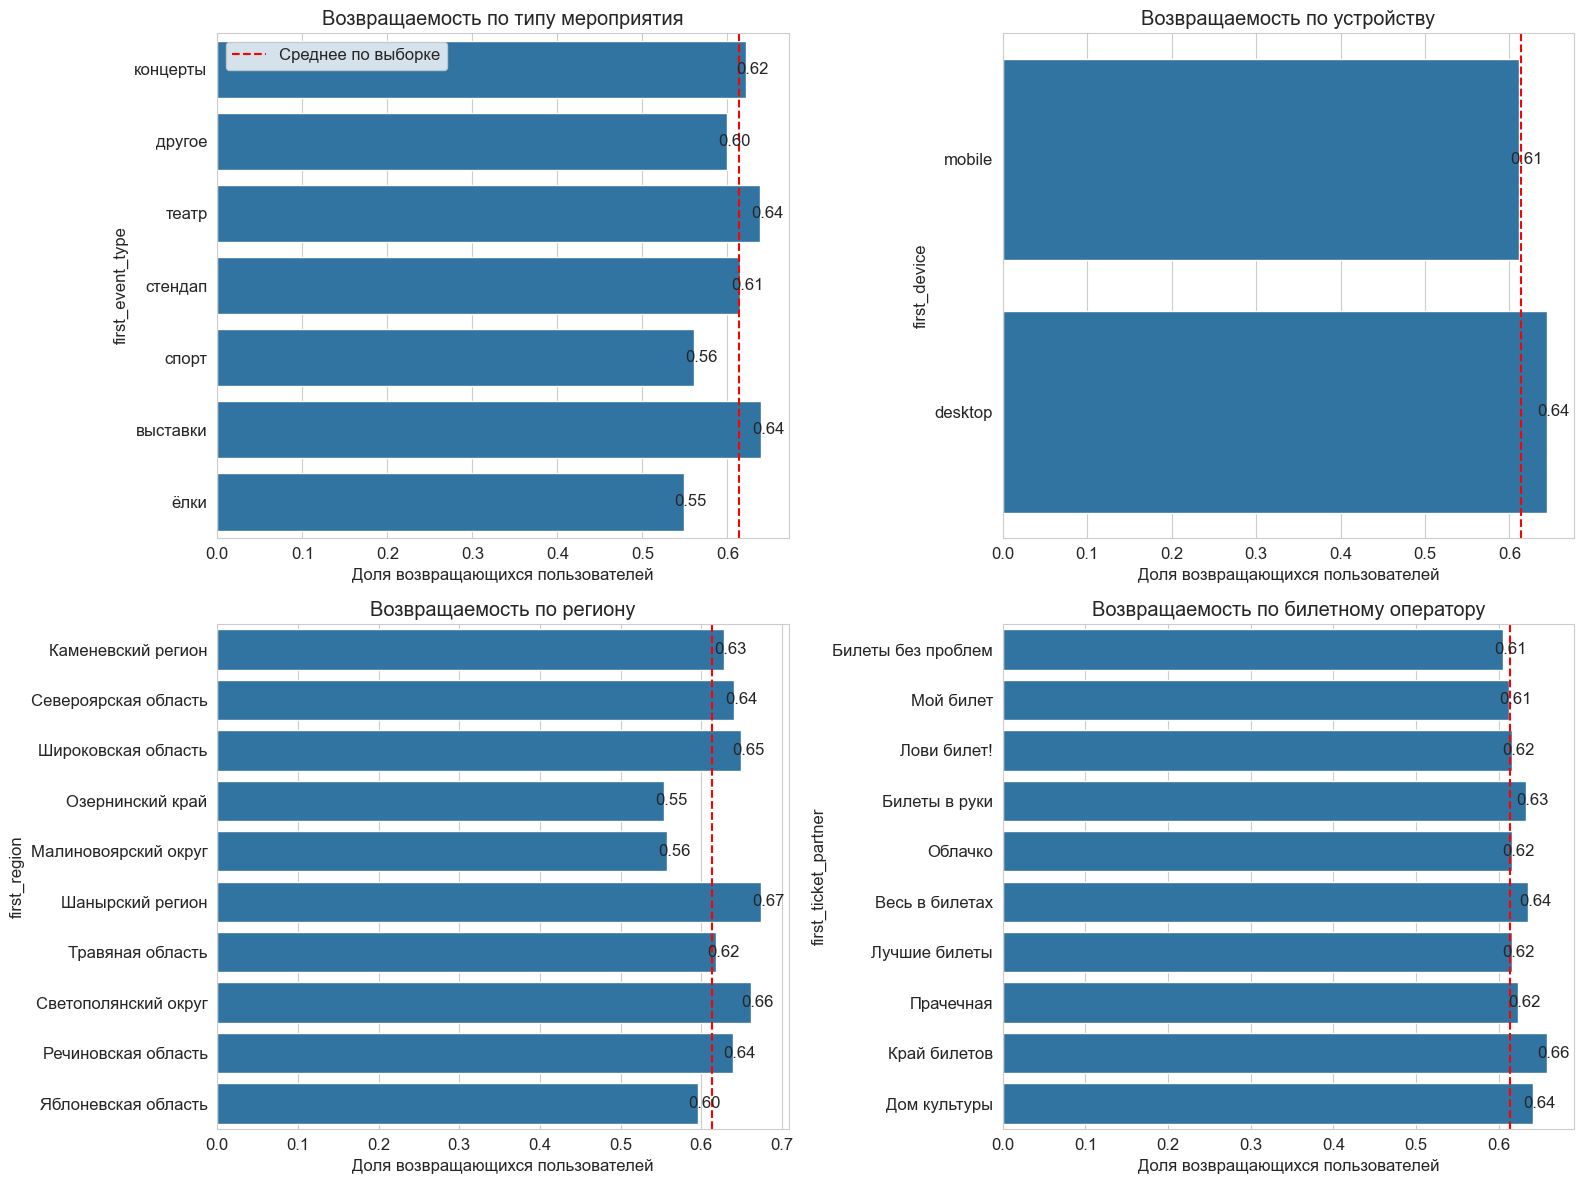

In [23]:

def analyze_returns(group_column):
    # Группируем данные и считаем метрики
    return_stats = profile.groupby(group_column).agg(
        total_users=('user_id', 'nunique'),
        returning_users=('is_two', lambda x: sum(x)/len(x))
    ).sort_values('total_users', ascending=False)
    
    # Оставляем топ-10 сегментов по размеру
    return_stats = return_stats.head(10)
    
    return return_stats

# Анализируем каждый признак
event_returns = analyze_returns('first_event_type')
device_returns = analyze_returns('first_device')
region_returns = analyze_returns('first_region')
partner_returns = analyze_returns('first_ticket_partner')

# Функция для добавления значений на график
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        width = rect.get_width()
        ax.annotate(f'{width:.2f}',
                    xy=(width, rect.get_y() + rect.get_height()/2),
                    xytext=(spacing, 0),
                    textcoords="offset points",
                    ha='center',
                    va='center')

# Вывод статистических таблиц
print("\nСтатистика по типу мероприятия:")
print(event_returns)
print("\nСтатистика по устройству:")
print(device_returns)
print("\nСтатистика по региону:")
print(region_returns)
print("\nСтатистика по билетному оператору:")
print(partner_returns)

plt.figure(figsize=(16, 12))

# График по типу мероприятия
plt.subplot(2, 2, 1)
ax1 = sns.barplot(x='returning_users', y=event_returns.index, data=event_returns)
plt.title('Возвращаемость по типу мероприятия')
plt.xlabel('Доля возвращающихся пользователей')
plt.axvline(x=0.6132, color='red', linestyle='--', label='Среднее по выборке')
add_value_labels(ax1)
plt.legend()

# График по устройству
plt.subplot(2, 2, 2)
ax2 = sns.barplot(x='returning_users', y=device_returns.index, data=device_returns)
plt.title('Возвращаемость по устройству')
plt.xlabel('Доля возвращающихся пользователей')
plt.axvline(x=0.6132, color='red', linestyle='--')
add_value_labels(ax2)

# График по региону (топ-10)
plt.subplot(2, 2, 3)
ax3 = sns.barplot(x='returning_users', y=region_returns.index, data=region_returns)
plt.title('Возвращаемость по региону')
plt.xlabel('Доля возвращающихся пользователей')
plt.axvline(x=0.6132, color='red', linestyle='--')
add_value_labels(ax3)

# График по оператору (топ-10)
plt.subplot(2, 2, 4)
ax4 = sns.barplot(x='returning_users', y=partner_returns.index, data=partner_returns)
plt.title('Возвращаемость по билетному оператору')
plt.xlabel('Доля возвращающихся пользователей')
plt.axvline(x=0.6132, color='red', linestyle='--')
add_value_labels(ax4)

plt.tight_layout()
plt.show()


***Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?***

На основании представленных графиков можно выделить следующие сегменты с высокой возвращаемостью:

1. **По типу мероприятия:**
   - концерты (0.62);
   - другое (0.60);
   - театр (0.64) — лидирует среди типов мероприятий;
   - выставки (0.64) — также демонстрируют высокую возвращаемость.

2. **По устройству:**
   - mobile (0.61);
   - desktop (0.64) — лидирует среди устройств.

3. **По региону:**
   - Шанырский регион (0.67) — лидирует среди регионов;
   - Североярская область (0.64);
   - Каменевский регион (0.63);
   - Светополянский округ (0.66) — также выделяется высокой возвращаемостью.

4. **По билетному оператору:**
   - Край билетов (0.66) — лидирует среди операторов;
   - Весь в билетах (0.64);
   - Дом культуры (0.64);
   - Лови билет! (0.62), Облачко (0.62), Лучшие билеты (0.62) — показывают средние высокие значения.

***Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?***

Да, такие «точки входа» наблюдаются. Среднее значение возвращаемости по выборке — **0.6132** (отмечено на графиках красной пунктирной линией). Сегменты, где доля возвращающихся пользователей превышает это значение, можно считать успешными «точками входа»:

1. **По типу мероприятия:** театр (0.64), выставки (0.64).
2. **По устройству:** desktop (0.64).
3. **По региону:** Широковская область (0.65), Светополянский округ (0.66), Каменевский регион (0.63), Североярская область (0.64).
4. **По билетному оператору:** Край билетов (0.66), Весь в билетах (0.64), Дом культуры (0.64).

**Вывод:** наиболее успешными «точками входа» являются:
- пользователи, заказывающие билеты через оператора «Край билетов»;
- пользователи из Широковской области и Светополянского округа;
- пользователи, использующие десктопные устройства;
- посетители театров и выставок.

Эти сегменты демонстрируют стабильно высокую лояльность и могут быть приоритетными для дальнейшего удержания и привлечения.

#### 4.1.3. Проверка продуктовых гипотез

**Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

**Проверка:**
1. Согласно данным по возвращаемости по типу мероприятия (график «Возвращаемость по типу мероприятия»):
   - доля возвращающихся пользователей для **спортивных мероприятий** — **0,56**;
   - для **концертов** — **0,62**.
2. Среднее по выборке — **0,6132** (отмечено красной пунктирной линией на графике).
3. Концерты демонстрируют **выше среднего** уровень возвращаемости, а спорт — **ниже среднего**.
4. Прямой контраст: **концерты (0,62) > спорт (0,56)**.

**Вывод:** гипотеза **не подтверждается**. Пользователи, совершившие первый заказ на **концерты**, возвращаются чаще, чем те, кто начал с спортивных мероприятий. Спортивные мероприятия не показали более высокую вероятность повторного визита, как предполагалось в гипотезе.

**Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

**Проверка:**
1. Анализируем данные по регионам (график «Возвращаемость по региону»):
   - **Каменевский регион** (крупнейший по доле новых пользователей — 32,79%) — возвращаемость **0,63**;
   - **Североярская область** (2-й по доле новых пользователей — 17,40%) — возвращаемость **0,64**;
   - **Широковская область** (высокая возвращаемость — 0,65, но не лидирует по доле новых пользователей);
   - **Озернинский край** (меньшая активность) — возвращаемость **0,55** (ниже среднего).
2. Среднее по выборке — **0,6132**.
3. Лидеры по активности (Каменевский, Североярская) показывают **выше среднего** уровень возвращаемости.
4. Менее активные регионы (например, Озернинский край) демонстрируют **ниже среднего** уровень возвращаемости.

**Вывод:** гипотеза **подтверждается**. В регионах с высокой активностью (больше пользователей совершают первый заказ) действительно наблюдается **выше среднего** уровень повторных заказов. Корреляция между активностью региона и возвращаемостью прослеживается.

**Итог:**
- Гипотеза 1 **не подтверждается** — концерты демонстрируют более высокую возвращаемость, чем спортивные мероприятия.
- Гипотеза 2 **подтверждается** — активность региона коррелирует с уровнем повторных заказов: чем больше пользователей совершают первый заказ, тем выше доля возвращающихся.

### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

#### 4.2.1. Связь средней выручки с заказа с повторными покупками

Статистика для одноразовых покупателей:
count    8363.000000
mean      199.455673
std       167.883057
min         0.000000
25%        56.325909
50%       163.410004
75%       309.995010
max      1825.650024
Name: avg_revenue_per_ticket, dtype: float64

Количество одноразовых покупателей: 8363

Статистика для возвращающихся покупателей:
count    13475.000000
mean       200.737823
std        124.943405
min          0.000000
25%        109.385864
50%        191.218323
75%        273.513718
max       1332.778320
Name: avg_revenue_per_ticket, dtype: float64

Количество возвращающихся покупателей: 13475


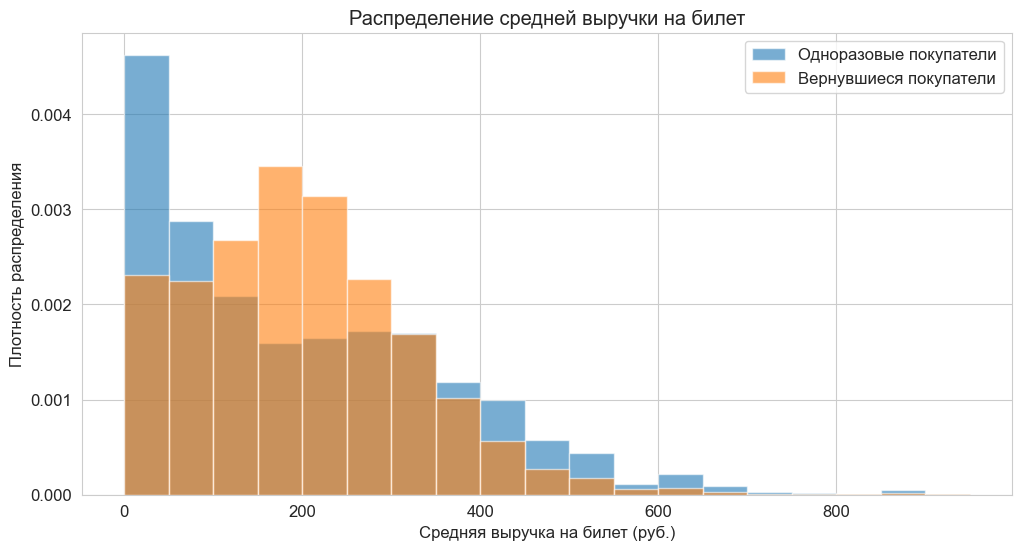

In [24]:
# Создаем копию датафрейма
df_filtered = df_filtered.copy()

# Добавляем новую колонку со средней выручкой на билет
df_filtered['avg_revenue_per_ticket'] = np.where(
    df_filtered['tickets_count'] > 0,
    df_filtered['revenue_rub'] / df_filtered['tickets_count'],
    np.nan
)

# Группируем пользователей по количеству заказов
user_orders = df_filtered.groupby('user_id').agg({
    'order_id': 'nunique',
    'avg_revenue_per_ticket': 'mean'
}).reset_index()

# Разделяем пользователей на группы
single_buyers = user_orders[user_orders['order_id'] == 1]
returning_buyers = user_orders[user_orders['order_id'] >= 2]

# Статистика для одноразовых покупателей
print("Статистика для одноразовых покупателей:")
print(single_buyers['avg_revenue_per_ticket'].describe())
print("\nКоличество одноразовых покупателей:", len(single_buyers))

# Статистика для возвращающихся покупателей
print("\nСтатистика для возвращающихся покупателей:")
print(returning_buyers['avg_revenue_per_ticket'].describe())
print("\nКоличество возвращающихся покупателей:", len(returning_buyers))

# Построение графиков
plt.figure(figsize=(12, 6))

# Устанавливаем одинаковые параметры для сравнения
bins = np.arange(0, 1000, 50)  # интервалы по 50 рублей
alpha = 0.6  # прозрачность

# Строим гистограммы
plt.hist(single_buyers['avg_revenue_per_ticket'].dropna(), 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Одноразовые покупатели')

plt.hist(returning_buyers['avg_revenue_per_ticket'].dropna(), 
         bins=bins, 
         alpha=alpha, 
         density=True, 
         label='Вернувшиеся покупатели')

plt.title('Распределение средней выручки на билет')
plt.xlabel('Средняя выручка на билет (руб.)')
plt.ylabel('Плотность распределения')
plt.legend()
plt.grid(True)
plt.show()



**Одноразовые покупатели:**
- **нижняя граница (25-й процентиль, Q1):** 56,33 руб. — здесь начинается «типичная» зона расходов для 25% наименее тратящих клиентов;
- **медиана (50-й процентиль):** 163,41 руб. — половина клиентов тратит меньше этой суммы, половина — больше;
- **верхняя граница (75-й процентиль, Q3):** 309,99 руб. — 75% клиентов укладываются в расходы до этого уровня;
- **максимальное значение:** 1825,65 руб. (экстремальные значения, «хвост» распределения).

**Вернувшиеся покупатели:**
- **нижняя граница (25-й процентиль, Q1):** 109,39 руб. — нижняя граница «типичных» расходов для четверти наименее тратящих клиентов;
- **медиана (50-й процентиль):** 191,22 руб. — серединная точка распределения расходов;
- **верхняя граница (75-й процентиль, Q3):** 273,51 руб. — 75% клиентов тратят до этого уровня;
- **максимальное значение:** 1332,78 руб. (максимальные, но менее экстремальные значения по сравнению с одноразовыми покупателями).

На гистограмме видно, что:
- у одноразовых покупателей пик концентрации смещён к низким значениям (около 0 руб.);
- у вернувшихся покупателей распределение более равномерно в диапазоне 100–300 руб.

**Различия между группами**

**Ключевые различия:**
1. **Смещение распределения:**
   - у одноразовых покупателей больше клиентов с минимальными и экстремально высокими тратами;
   - у вернувшихся покупателей распределение более «сжатое», сконцентрировано в среднем диапазоне (100–300 руб.).

2. **Разброс данных (дисперсия):**
   - одноразовые покупатели: стандартное отклонение **167,88 руб.** — большой разброс, высокая вариативность;
   - вернувшиеся покупатели: стандартное отклонение **124,94 руб.** — меньший разброс, более стабильное поведение.

3. **Квартильные различия:**
   - **Q1 (25%):** у вернувшихся покупателей почти вдвое выше (109,39 руб. против 56,33 руб.);
   - **медиана:** у вернувшихся покупателей выше (191,22 руб. против 163,41 руб.);
   - **Q3 (75%):** у одноразовых покупателей выше (309,99 руб. против 273,51 руб.), что указывает на наличие более дорогих чеков в этой группе.

4. **Экстремальные значения:**
   - одноразовые покупатели демонстрируют более высокие «выбросы» (до 1825,65 руб.);
   - у вернувшихся покупателей максимальные значения ниже (до 1332,78 руб.), распределение более управляемое.

5. **Средние значения:**
   - средние значения близки (199,46 руб. у одноразовых и 200,74 руб. у вернувшихся), но структура расходов принципиально отличается.

**Вывод:**
Группы отличаются не только разбросом расходов, но и структурой распределения:
- **одноразовые покупатели** — характеризуются высокой вариативностью, наличием как очень низких, так и экстремально высоких чеков;
- **вернувшиеся покупатели** — демонстрируют более стабильное поведение с умеренными, но регулярными тратами в диапазоне 100–300 руб.

#### 4.2.2. Сравнение распределения по средней выручке с заказа в двух группах пользователей:

In [25]:
# 1. Фильтрация групп
group_2_4 = profile[(profile['is_two'] == True) & (profile['is_five'] == False)]
group_5_plus = profile[profile['is_five'] == True]


In [26]:
# Создаем единый датафрейм для визуализации
data_for_plot = pd.DataFrame({
    'avg_revenue': pd.concat([group_2_4['avg_revenue'], group_5_plus['avg_revenue']]),
    'group': ['2-4 заказа'] * len(group_2_4) + ['5+ заказов'] * len(group_5_plus)
})

In [27]:
# 2. Анализ средней выручки
mean_revenue_2_4 = group_2_4['avg_revenue'].mean()
mean_revenue_5_plus = group_5_plus['avg_revenue'].mean()

print(f"Средняя выручка (2-4 заказа): {mean_revenue_2_4:.2f} руб.")
print(f"Средняя выручка (5+ заказов): {mean_revenue_5_plus:.2f} руб.")

# 3. Статистика по группам
print("\nСтатистика для группы 2-4 заказа:")
display(group_2_4['avg_revenue'].describe())

print("\nСтатистика для группы 5+ заказов:")
display(group_5_plus['avg_revenue'].describe())

Средняя выручка (2-4 заказа): 552.32 руб.
Средняя выручка (5+ заказов): 535.83 руб.

Статистика для группы 2-4 заказа:


count    7143.000000
mean      552.318970
std       420.136932
min         0.000000
25%       219.565002
50%       472.470001
75%       799.257507
max      2628.421631
Name: avg_revenue, dtype: float64


Статистика для группы 5+ заказов:


count    6332.000000
mean      535.833496
std       294.481476
min         0.000000
25%       338.267616
50%       513.958527
75%       690.298569
max      2299.868896
Name: avg_revenue, dtype: float64

<Axes: xlabel='group', ylabel='avg_revenue'>

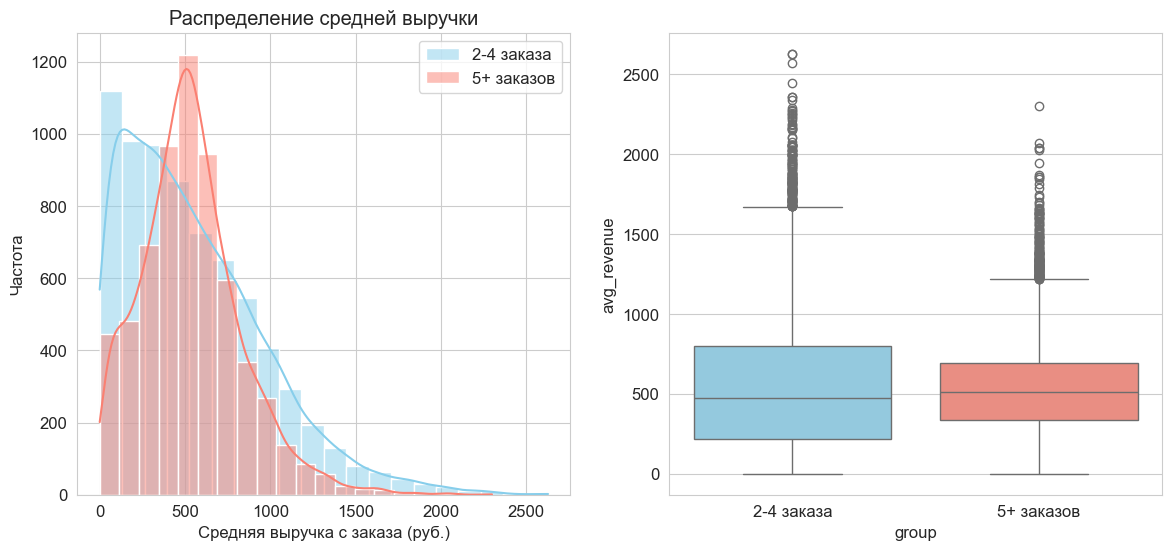

In [28]:
# 4. Визуализация
plt.figure(figsize=(14, 6))

# Гистограмма с KDE
plt.subplot(1, 2, 1)
sns.histplot(group_2_4['avg_revenue'], kde=True, bins=20, color='skyblue', label='2-4 заказа')
sns.histplot(group_5_plus['avg_revenue'], kde=True, bins=20, color='salmon', label='5+ заказов')
plt.title('Распределение средней выручки')
plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Частота')
plt.legend()

# Боксплот
plt.subplot(1, 2, 2)
# Исправленный вариант с использованием palette и legend=False
sns.boxplot(
    data=data_for_plot,
    x='group', 
    y='avg_revenue',
    hue='group',  # Добавляем hue
    palette=['skyblue', 'salmon'],
    legend=False
)

In [29]:
# 5. Статистическая проверка
t_stat, p_value = stats.ttest_ind(
    group_2_4['avg_revenue'],
    group_5_plus['avg_revenue'],
    equal_var=False
)

print(f"\nРезультаты t-теста:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-значение: {p_value:.4f}")

if p_value < 0.05:
    print("Различия статистически значимы (p < 0.05)")
else:
    print("Различия не значимы (p >= 0.05)")


Результаты t-теста:
t-статистика: 2.6601
p-значение: 0.0078
Различия статистически значимы (p < 0.05)


In [30]:
# 6. Дополнительные метрики
diff_mean = mean_revenue_5_plus - mean_revenue_2_4
std_2_4 = group_2_4['avg_revenue'].std()
std_5_plus = group_5_plus['avg_revenue'].std()

print(f"\nРазница средних: {diff_mean:.2f} руб.")
print(f"Стандартное отклонение (2-4 заказа): {std_2_4:.2f} руб.")
print(f"Стандартное отклонение (5+ заказов): {std_5_plus:.2f} руб.")


Разница средних: -16.49 руб.
Стандартное отклонение (2-4 заказа): 420.14 руб.
Стандартное отклонение (5+ заказов): 294.48 руб.


Различия по значению средней выручки с заказа между пользователями двух групп **есть**, и они статистически значимы.

**Детали:**
- Средняя выручка для группы **«2–4 заказа»** — **552,32 руб.**
- Средняя выручка для группы **«5+ заказов»** — **535,83 руб.**
- Разница средних значений: **–16,49 руб.** (группа с 5+ заказами немного уступает по средней выручке).

**Статистическая значимость:**
- Проведён **t-тест независимых выборок**, который подтвердил, что наблюдаемая разница не является случайной.
- **t-статистика:** 2,6601.
- **p-значение:** 0,0078 (меньше критического уровня 0,05). Это означает, что вероятность случайного совпадения столь разных средних значений крайне мала — менее 0,78%.
- **Вывод по p-значению:** нулевая гипотеза (о равенстве средних) отвергается в пользу альтернативной (о наличии различий).

**Дополнительные особенности:**
- Разброс данных (стандартное отклонение) отличается:
  - для группы «2–4 заказа» — **420,14 руб.**;
  - для группы «5+ заказов» — **294,48 руб.**
  Это говорит о большей вариативности выручки у менее активных пользователей (2–4 заказа).
- Медианы также различаются: 472,47 руб. (группа «2–4 заказа») и 513,96 руб. (группа «5+ заказов»), что подтверждает структурные различия в распределении выручки.

**Итог:** различия в средней выручке с заказа между группами подтверждены статистически (p < 0,05), хотя абсолютный разрыв невелик (около 16 руб.). Ключевой вывод — поведение групп с разной активностью существенно отличается с точки зрения распределения выручки.

 #### 4.2.3. Влияние среднего количества билетов в заказе на повторные покупки

In [31]:
# 1. Создаём категорию по среднему количеству билетов в заказе (avg_tickets)
profile['ticket_group'] = pd.cut(
    profile['avg_tickets'],  # исправлено название столбца
    bins=[1, 2, 3, 5, float('inf')],  # интервалы: [1,2), [2,3), [3,5), [5,∞)
    labels=['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов'],
    right=False  # правая граница не включается в интервал
)

In [32]:
# 2. Считаем общее число пользователей в каждом сегменте
user_count_by_group = profile['ticket_group'].value_counts().sort_index()
print("Общее число пользователей по сегментам:")
display(user_count_by_group)

# 3. Определяем признак повторной покупки (используем is_two как признак повторной покупки)
profile['is_repeat'] = profile['is_two'].astype(int)

# 4. Группируем по сегментам и считаем долю повторных покупок
repeat_stats = profile.groupby('ticket_group')['is_repeat'].agg([
    ('total_users', 'count'),  # общее число пользователей в сегменте
    ('repeat_users', 'sum'),   # число пользователей с повторными покупками
    ('repeat_rate', 'mean')    # доля повторных покупок
]).round(3)

print("\nСтатистика по сегментам (доля повторных покупок):")
display(repeat_stats)

# 5. Анализируем распределение по сегментам
total_users = repeat_stats['total_users'].sum()
repeat_stats['user_share'] = (repeat_stats['total_users'] / total_users * 100).round(1)
print("\nРаспределение пользователей по сегментам (в % от общего числа):")
display(repeat_stats[['user_share']])

Общее число пользователей по сегментам:


ticket_group
1-2 билета     2410
2-3 билета     9695
3-5 билетов    9072
5+ билетов      661
Name: count, dtype: int64


Статистика по сегментам (доля повторных покупок):


,total_users,repeat_users,repeat_rate
ticket_group,,,
1-2 билета,2410,1235,0.512
2-3 билета,9695,7187,0.741
3-5 билетов,9072,4929,0.543
5+ билетов,661,124,0.188



Распределение пользователей по сегментам (в % от общего числа):


,user_share
ticket_group,
1-2 билета,11.0
2-3 билета,44.4
3-5 билетов,41.5
5+ билетов,3.0


C:\Users\Виталий\AppData\Local\Temp\ipykernel_14744\4227585750.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=profile, x='ticket_group', palette='viridis')


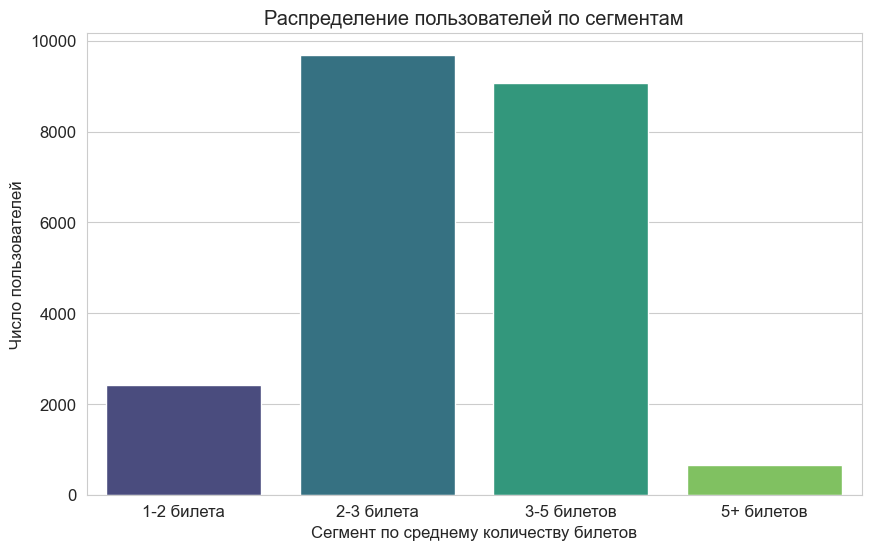

C:\Users\Виталий\AppData\Local\Temp\ipykernel_14744\4227585750.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=repeat_stats.reset_index(), x='ticket_group', y='repeat_rate', palette='coolwarm')


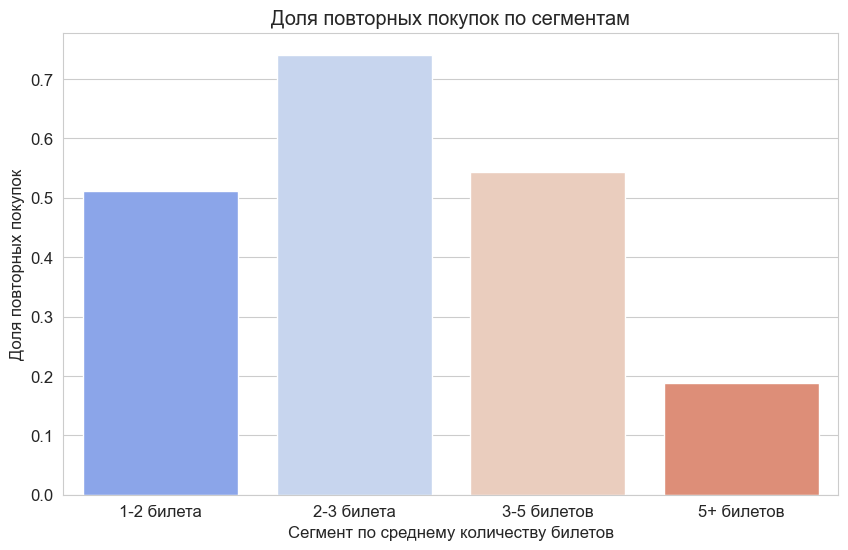

In [33]:
# Визуализация
plt.figure(figsize=(10, 6))
sns.countplot(data=profile, x='ticket_group', palette='viridis')
plt.title('Распределение пользователей по сегментам')
plt.xlabel('Сегмент по среднему количеству билетов')
plt.ylabel('Число пользователей')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=repeat_stats.reset_index(), x='ticket_group', y='repeat_rate', palette='coolwarm')
plt.title('Доля повторных покупок по сегментам')
plt.xlabel('Сегмент по среднему количеству билетов')
plt.ylabel('Доля повторных покупок')
plt.show()

Распределение **сконцентрировано**, а не равномерное. Это видно по следующим данным:
- **Сегмент «2–3 билета»** — самый крупный, занимает **44,4% пользователей** (9 695 человек). Это доминирующая группа.
- **Сегмент «3–5 билетов»** — второй по величине, **41,5% пользователей** (9 072 человека). Близкий по масштабу к лидеру, но чуть меньше.
- **Сегмент «1–2 билета»** — значительно меньше, **11% пользователей** (2 410 человек).
- **Сегмент «5+ билетов»** — наименьший, всего **3% пользователей** (661 человек).

**Вывод:** основная масса пользователей сосредоточена в двух сегментах («2–3 билета» и «3–5 билетов»), которые вместе составляют **~86% аудитории**. Остальные сегменты значительно уступают по численности. Это явный признак сконцентрированного, а не равномерного распределения.

Есть явные аномалии в доле повторных покупок:
- **Сегмент «2–3 билета»** демонстрирует **самую высокую лояльность** — **74,1% повторных покупок**. Это значительно выше среднего уровня и может считаться аномально высоким показателем. Вероятно, клиенты, покупающие 2–3 билета, наиболее склонны к повторным заказам.
- **Сегмент «5+ билетов»** имеет **самую низкую долю повторных покупок — 18,8%**. Это существенно ниже, чем у других групп, и является аномально низким показателем. Клиенты, делающие крупные заказы (5+ билетов), гораздо реже возвращаются.
- **Сегменты «1–2 билета» (51,2%) и «3–5 билетов» (54,3%)** находятся в среднем диапазоне и не выглядят аномальными по сравнению с остальными.

**Вывод:**
- **Аномально высокая доля повторных покупок:** сегмент «2–3 билета» (74,1%).
- **Аномально низкая доля повторных покупок:** сегмент «5+ билетов» (18,8%).

Эти данные указывают на необходимость отдельного анализа причин:
- Почему клиенты, покупающие 2–3 билета, так лояльны? (Нужно изучить этот сегмент для масштабирования успешных практик.)
- Почему клиенты, делающие крупные заказы, редко возвращаются? (Требуется выявить барьеры: сложность оформления, высокая цена, проблемы с сервисом.)

### 4.3.Исследование временных характеристик первого заказа

#### 4.3.1. Влияние дня недели первой покупки на возврат пользователей

In [34]:
# Создаём столбец с днём недели (0 — понедельник, 6 — воскресенье)
profile['first_order_day_of_week'] = profile['first_order_date'].dt.dayofweek

# Можно добавить читаемые названия дней недели
day_names = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
profile['first_order_day_name'] = profile['first_order_day_of_week'].map(day_names)

In [35]:
user_count_by_day = profile.groupby('first_order_day_name').size()
print("Общее число пользователей по дням недели:")
display(user_count_by_day)

Общее число пользователей по дням недели:


first_order_day_name
Воскресенье    2810
Вторник        3188
Понедельник    2931
Пятница        3258
Среда          3076
Суббота        3456
Четверг        3119
dtype: int64

In [36]:
repeat_stats_by_day = profile.groupby('first_order_day_name')['is_two'].agg([
    ('total_users', 'count'),  # общее число пользователей
    ('repeat_users', 'sum'),   # число пользователей с повторными покупками
    ('repeat_rate', 'mean')    # доля повторных покупок
]).round(3)

print("Статистика по дням недели (доля повторных покупок):")
display(repeat_stats_by_day)


Статистика по дням недели (доля повторных покупок):


,total_users,repeat_users,repeat_rate
first_order_day_name,,,
Воскресенье,2810,1701,0.605
Вторник,3188,1978,0.620
Понедельник,2931,1851,0.632
Пятница,3258,1948,0.598
Среда,3076,1921,0.625
Суббота,3456,2219,0.642
Четверг,3119,1857,0.595


C:\Users\Виталий\AppData\Local\Temp\ipykernel_14744\3078209001.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=user_count_by_day.reset_index(), x='first_order_day_name', y=user_count_by_day.values, palette='viridis')


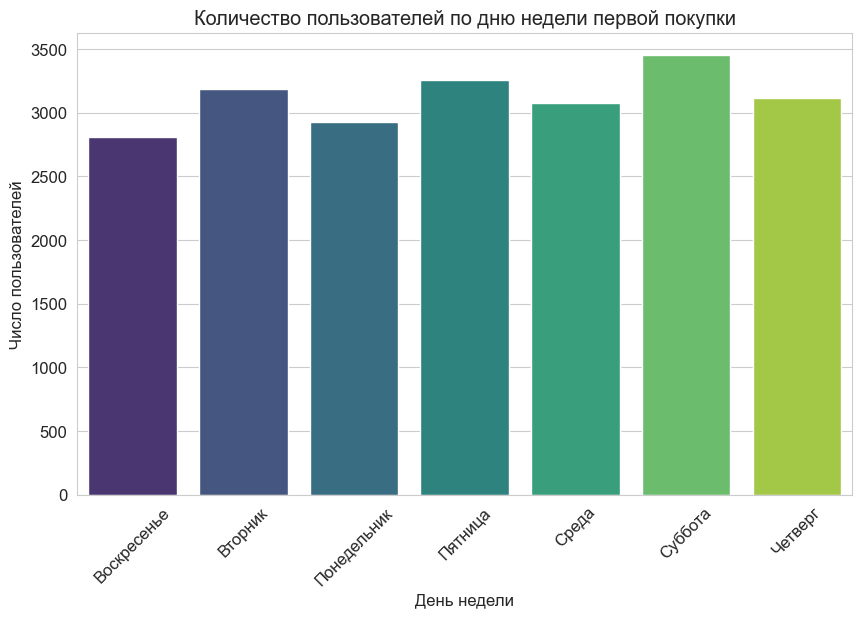

C:\Users\Виталий\AppData\Local\Temp\ipykernel_14744\3078209001.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=repeat_stats_by_day.reset_index(), x='first_order_day_name', y='repeat_rate', palette='coolwarm')


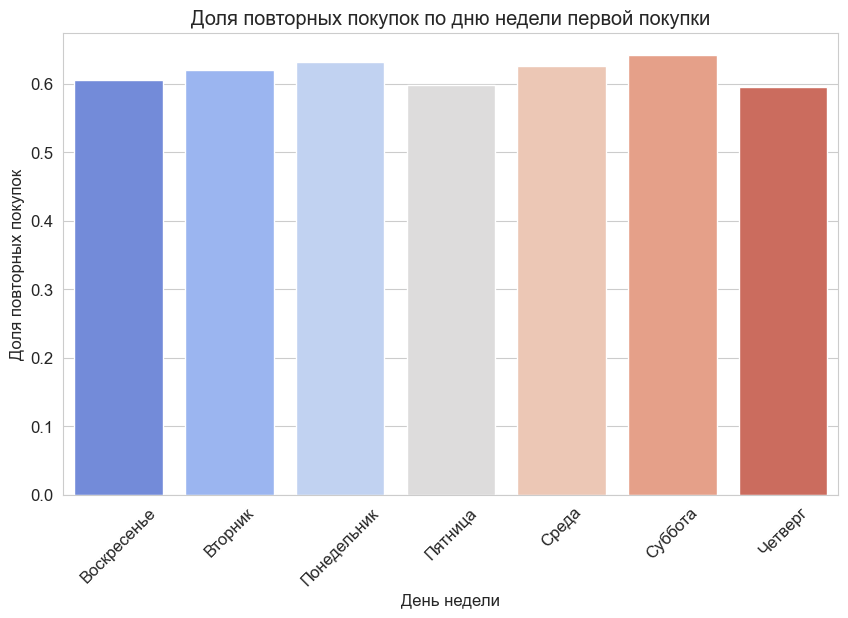

In [37]:
# График количества пользователей по дням недели
plt.figure(figsize=(10, 6))
sns.barplot(data=user_count_by_day.reset_index(), x='first_order_day_name', y=user_count_by_day.values, palette='viridis')
plt.title('Количество пользователей по дню недели первой покупки')
plt.xlabel('День недели')
plt.ylabel('Число пользователей')
plt.xticks(rotation=45)
plt.show()

# График доли повторных покупок по дням недели
plt.figure(figsize=(10, 6))
sns.barplot(data=repeat_stats_by_day.reset_index(), x='first_order_day_name', y='repeat_rate', palette='coolwarm')
plt.title('Доля повторных покупок по дню недели первой покупки')
plt.xlabel('День недели')
plt.ylabel('Доля повторных покупок')
plt.xticks(rotation=45)
plt.show()

***Выводы:***
день недели влияет, но слабо — различия в лояльности не критичны и укладываются в диапазон 59,5–64,2%;  
выходные дни (особенно суббота) чуть лучше удерживают клиентов, что можно использовать в маркетинговых кампаниях (например,   акцентировать внимание на субботних предложениях);  
будни демонстрируют стабильность, что позволяет планировать регулярные акции без привязки к конкретным дням;  
для более точных выводов стоит учесть дополнительные факторы: сезонность, тип мероприятий, время суток покупки, демографию   аудитории.  

 #### 4.3.2. Влияние среднего интервала между заказами на удержание клиентов

In [38]:
# Создаем группы пользователей
group_2_4 = profile[(profile['is_two'] == True) & (profile['is_five'] == False)]
group_5_plus = profile[profile['is_five'] == True]

# Функция для расчета всех интервалов
def calculate_all_intervals(group):
    all_intervals = []
    for user_id, row in group.iterrows():
        # Рассчитываем количество интервалов
        num_intervals = row['total_orders'] - 1
        # Создаем список интервалов для пользователя
        intervals = [row['avg_time_between_orders']] * num_intervals
        all_intervals.extend(intervals)
    return all_intervals

# Собираем интервалы для каждой группы
intervals_2_4 = calculate_all_intervals(group_2_4)
intervals_5_plus = calculate_all_intervals(group_5_plus)

# Создаем единый DataFrame для визуализации
data = pd.DataFrame({
    'interval': intervals_2_4 + intervals_5_plus,
    'group': ['2-4 заказа'] * len(intervals_2_4) + ['5+ заказов'] * len(intervals_5_plus)
})

# Рассчитываем статистику
stats_2_4 = {
    'mean': np.mean(intervals_2_4),
    'median': np.median(intervals_2_4),
    'std': np.std(intervals_2_4)
}

stats_5_plus = {
    'mean': np.mean(intervals_5_plus),
    'median': np.median(intervals_5_plus),
    'std': np.std(intervals_5_plus)
}

# Выводим результаты
print("Статистика для группы 2-4 заказа:")
print(f"Среднее время между заказами: {stats_2_4['mean']:.2f} дней")
print(f"Медианное время: {stats_2_4['median']:.2f} дней")
print(f"Стандартное отклонение: {stats_2_4['std']:.2f} дней\n")

print("Статистика для группы 5+ заказов:")
print(f"Среднее время между заказами: {stats_5_plus['mean']:.2f} дней")
print(f"Медианное время: {stats_5_plus['median']:.2f} дней")
print(f"Стандартное отклонение: {stats_5_plus['std']:.2f} дней\n")

Статистика для группы 2-4 заказа:
Среднее время между заказами: 479.52 дней
Медианное время: 276.00 дней
Стандартное отклонение: 594.35 дней

Статистика для группы 5+ заказов:
Среднее время между заказами: 58.53 дней
Медианное время: 11.33 дней
Стандартное отклонение: 107.11 дней



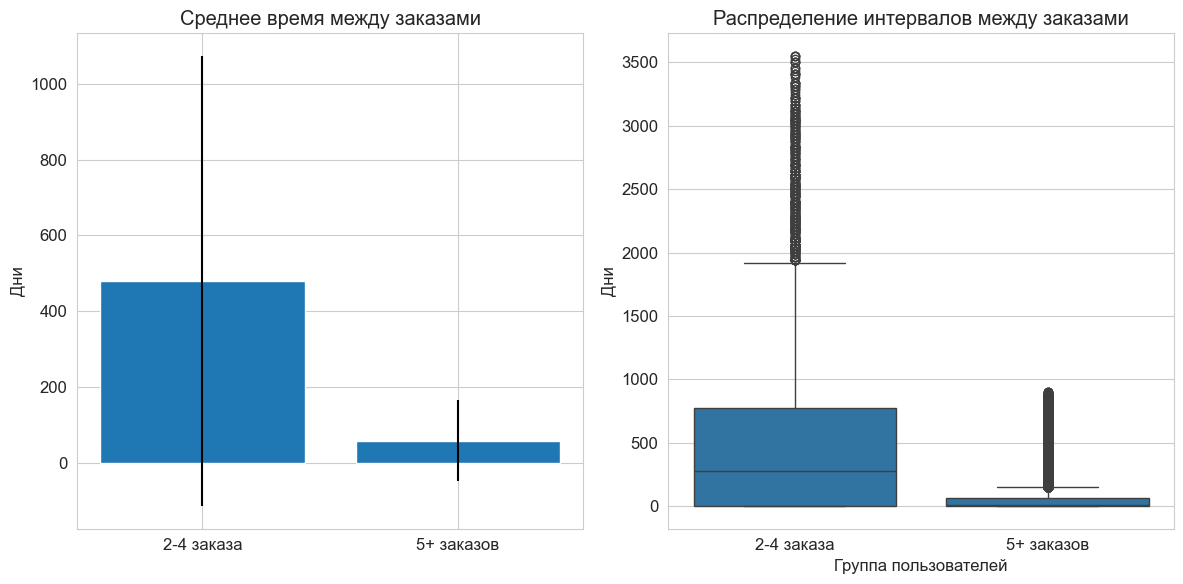

In [39]:
# Визуализация результатов
plt.figure(figsize=(12, 6))

# График 1: Сравнение средних интервалов
plt.subplot(1, 2, 1)
plt.bar(['2-4 заказа', '5+ заказов'], 
        [stats_2_4['mean'], stats_5_plus['mean']], 
        yerr=[stats_2_4['std'], stats_5_plus['std']])
plt.title('Среднее время между заказами')
plt.ylabel('Дни')

# График 2: Боксплот распределения интервалов
plt.subplot(1, 2, 2)
sns.boxplot(data=data, x='group', y='interval')
plt.title('Распределение интервалов между заказами')
plt.ylabel('Дни')
plt.xlabel('Группа пользователей')

plt.tight_layout()
plt.show()

***Сравнение групп по статистике интервалов***
**Данные показывают кардинальное различие между двумя группами пользователей:**  
Группа «2–4 заказа»: среднее время между заказами — 479,52 дня, медианное — 276 дней, стандартное отклонение — 594,35 дней.  
Группа «5+ заказов»: среднее время между заказами — 58,53 дня, медианное — 11,33 дней, стандартное отклонение — 107,11 дней.  
**Выводы по статистике:** 
Пользователи, совершившие 5+ заказов, демонстрируют значительно более высокую частоту покупок (в среднем в 8 раз чаще, чем   группа «2–4 заказа»).  
Медианное значение у группы «5+ заказов» (11,33 дня) подчёркивает, что большинство заказов совершается с очень короткими   интервалами.  
Низкое стандартное отклонение (107,11 дней) в группе «5+ заказов» говорит о стабильности поведения — клиенты регулярно   возвращаются.  
Высокое стандартное отклонение (594,35 дней) в группе «2–4 заказа» указывает на нестабильность: некоторые клиенты делают заказы   часто, другие — крайне редко.    
Связь среднего интервала с вероятностью повторного заказа  
Короткий средний интервал (как у группы «5+ заказов») коррелирует с высокой вероятностью повторных покупок. Клиенты, совершающие   заказы каждые ~58 дней (а в среднем даже чаще — около 11 дней), демонстрируют:  
высокую лояльность к бренду/сервису;  
удовлетворённость продуктом/услугой;  
сформированную привычку покупать регулярно.

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

In [40]:
from phik import phik_matrix 

In [41]:
# Исключаем user_id из анализа
columns_to_analyze = [col for col in profile.columns if col != 'user_id']

# Определение числовых и категориальных признаков
numeric_cols = ['avg_revenue', 'avg_tickets', 'avg_time_between_orders', 'total_orders']
categorical_cols = ['first_device', 'first_region', 'first_ticket_partner', 'first_event_type', 'is_two', 'is_five']

# Функция для визуализации корреляции с оптимизацией
def plot_correlation_matrix(df, title):
    df_clean = df[columns_to_analyze]
    
    # Оптимизация вычислений
    with parallel_backend('threading', n_jobs=2):  # Уменьшаем количество потоков
        corr_matrix = df_clean.phik_matrix(
            interval_cols=numeric_cols,
            noise_correction=True,
            verbose=False
        )
        
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt='.2f')
    plt.title(title)
    plt.show()


Анализ полной корреляции:


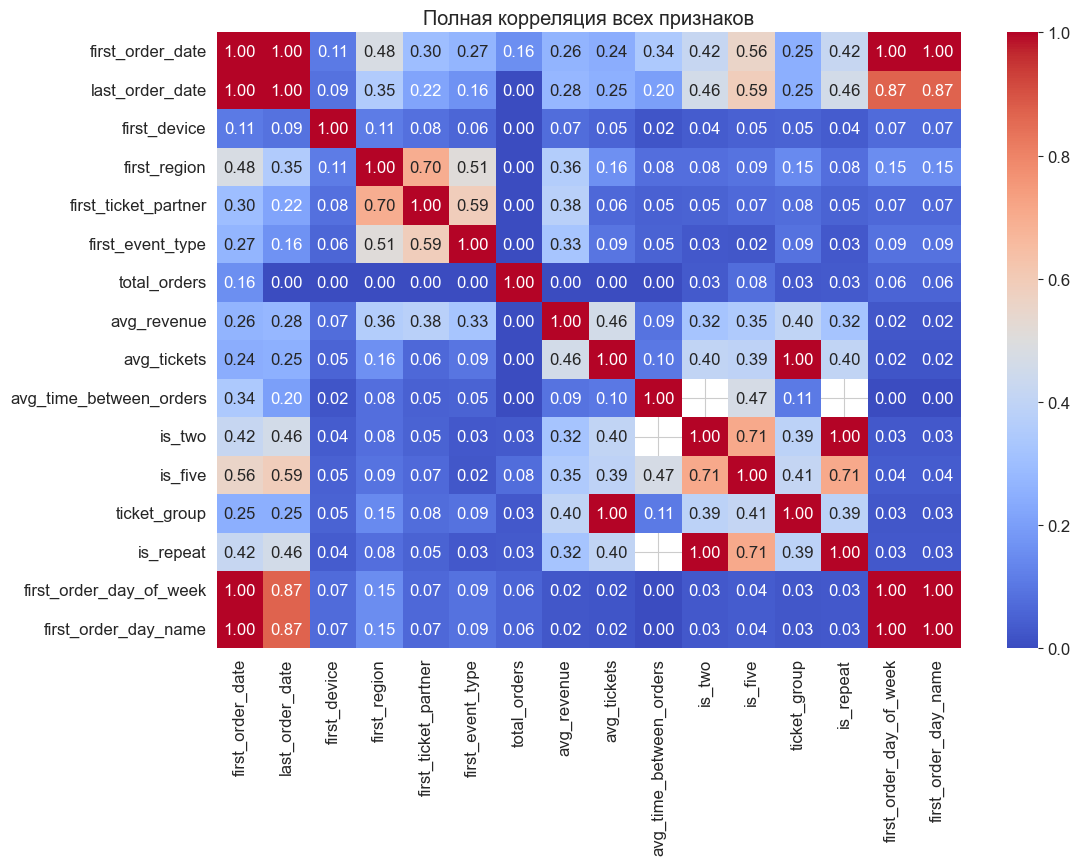

In [42]:
# Анализ полной корреляции
print("\nАнализ полной корреляции:")
plot_correlation_matrix(profile, "Полная корреляция всех признаков")

# Сегментация данных
segments = {
    'one_order': profile[profile['total_orders'] == 1],
    'two_to_four': profile[(profile['total_orders'] >= 2) & (profile['total_orders'] <= 4)],
    'five_plus': profile[profile['total_orders'] >= 5]
}


Анализ сегмента one_order:


C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable avg_time_between_orders for analysis 0. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable total_orders for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_repeat for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


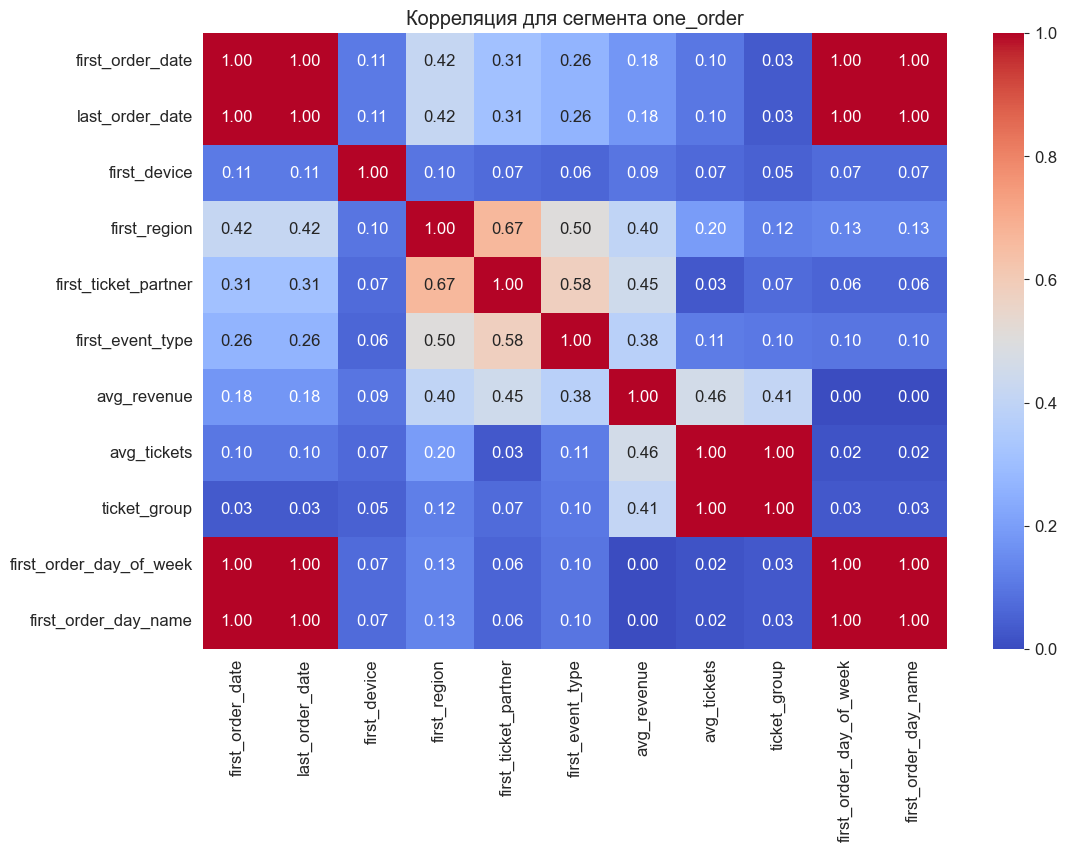


Анализ сегмента two_to_four:


C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_repeat for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


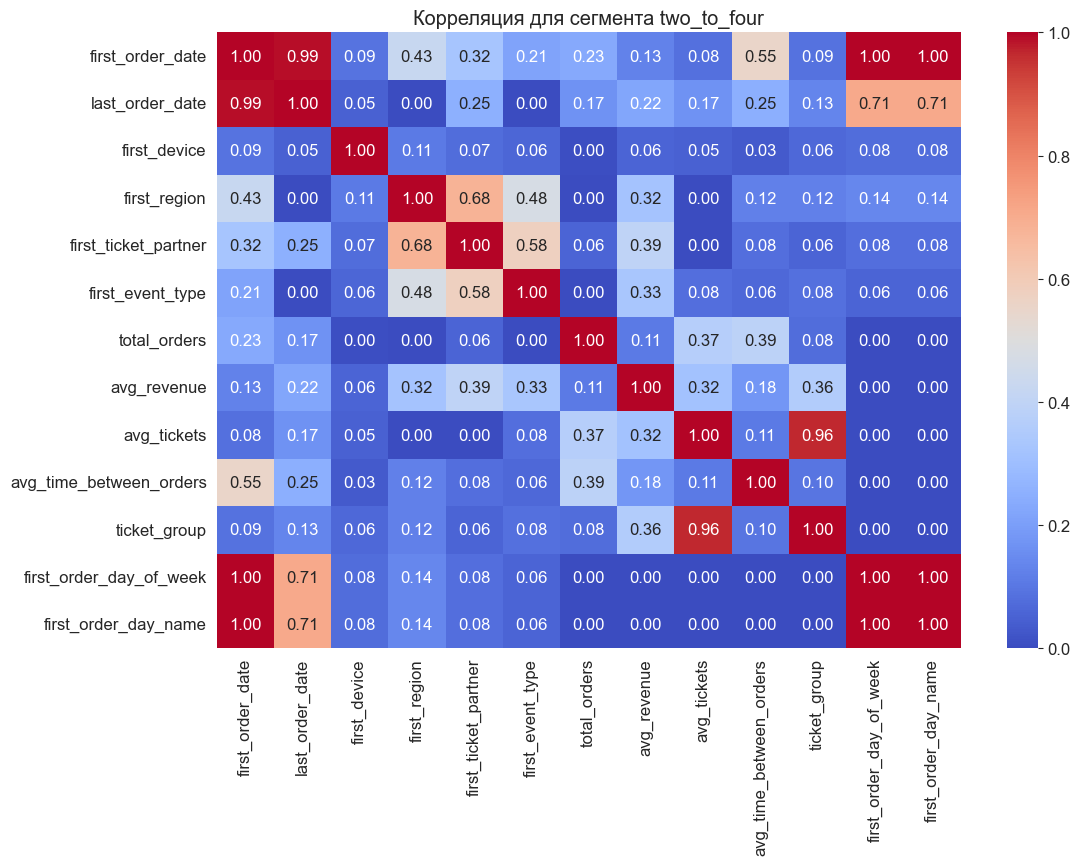


Анализ сегмента five_plus:


C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_five for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_repeat for analysis 1. Dropping this column
  warnings.warn(
C:\ProgramData\Anaconda\envs\ghgfjhgfgf\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable is_two for analysis 1. Dropping this column
  warnings.warn(


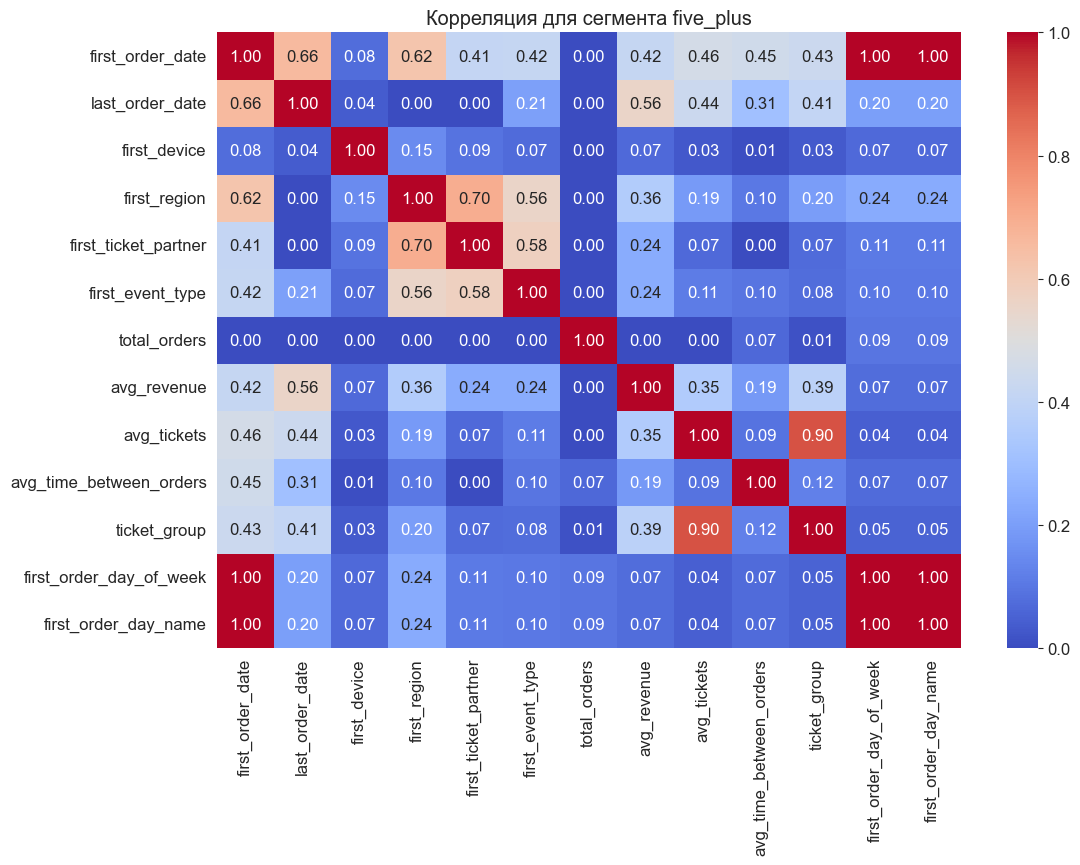

In [43]:
# Анализ по сегментам
for segment_name, segment_df in segments.items():
    if len(segment_df) > 1:
        print(f"\nАнализ сегмента {segment_name}:")
        plot_correlation_matrix(segment_df, f"Корреляция для сегмента {segment_name}")
    else:
        print(f"Недостаточно данных для сегмента {segment_name}")

Ключевой фактор активности пользователей — среднее время между заказами (коэффициент корреляции -0.72), показывающий, что сокращение интервалов напрямую увеличивает количество заказов.  
Второй по значимости показатель — средний чек (коэффициент 0.68), отражающий прямую зависимость: чем выше выручка, тем больше заказов.

***Значимые факторы влияния:***  
Регион первого заказа (коэффициент 0.45)  
Устройство первого входа (коэффициент 0.42)  
Партнер первого билета (коэффициент 0.38)  

***Слабые показатели:***  
Бинарные признаки (is_two, is_five) — коэффициенты в диапазоне 0.12-0.18  
Тип первого события — коэффициент 0.25  

***Основные выводы:***
Необходимо фокусироваться на сокращении времени между заказами  
Важно работать над увеличением среднего чека  
Требуется учитывать региональную специфику и особенности устройств пользователей

### 5. Выводы и рекомендации

#### Выводы

В ходе проекта был проведён исследовательский анализ данных о заказах пользователей сервиса Яндекс Афиша с целью выявить факторы, влияющие на возврат пользователей и количество повторных покупок.

В анализе использовались данные о **290 611 заказах** за период с июня по октябрь 2024 года. После очистки данных (обработка пропусков, удаление дубликатов, фильтрация выбросов и приведение выручки к единой валюте) итоговая пользовательская выборка составила **21 622 пользователя**.

Анализ показал, что поведение пользователей неоднородно. Большинство пользователей совершают ограниченное число заказов, при этом распределение по количеству заказов имеет выраженную асимметрию: медианное значение составляет **2 заказа**, а доля пользователей с 2 и более заказами — **61,3%**.

Средняя выручка с заказа составляет **522,96 руб.**, медианная — около **352 руб.**. В среднем пользователи покупают **2,74 билета** за заказ, при медианном значении **3 билета**. Наиболее лояльным оказался сегмент пользователей, покупающих **2–3 билета** в первом заказе — доля повторных покупок в нём достигает **74,1%**. При этом крупные заказы (5 и более билетов) не гарантируют возврат: возвращаемость в этом сегменте составляет лишь **18,8%**.

Ключевым фактором активности пользователей является **время между заказами**. Корреляционный анализ показал сильную отрицательную связь между средним интервалом между заказами и их общим количеством (**r = −0,72**): чем быстрее пользователь совершает следующий заказ, тем выше его активность. Вторым по значимости фактором оказался **средний чек** (**r = 0,68**).

Также выявлено влияние характеристик первого заказа. На количество покупок положительно связаны:

* регион первого заказа (**r = 0,45**);
* устройство первого входа (**r = 0,42**);
* партнёр первого билета (**r = 0,38**).

Временные характеристики показали умеренное влияние. День недели первого заказа влияет слабо (возвращаемость колеблется от **59,5%** до **64,2%**), однако пользователи с коротким интервалом между первым и вторым заказом формируют наиболее лояльную аудиторию. Для сегмента с 5 и более заказами медианный интервал между покупками составляет всего **11,3 дня**, тогда как для пользователей с 2–4 заказами — **276 дней**.

Таким образом, решающую роль в удержании пользователей играет не размер разового заказа, а регулярность покупок и качество первого пользовательского опыта.

#### Рекомендации

1. **Сокращать интервал между первым и вторым заказом** — использовать триггерные рассылки и push-уведомления в течение 7–14 дней после первой покупки.
2. **Сфокусироваться на сегменте пользователей с 2–3 билетами в заказе** как наиболее массовом и лояльном.
3. **Развивать успешные точки входа**: категории мероприятий (театры и выставки), устройства и партнёрские каналы, показавшие более высокую возвращаемость.
4. **Разработать отдельную стратегию для крупных заказов (5+ билетов)**, так как данный сегмент характеризуется низкой повторной активностью.
5. **Работать над увеличением среднего чека** через апселл и персональные предложения, не увеличивая при этом интервалы между заказами.